### Задача работы - построить скоринг-модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента.


### 1. Подготовка к работе
### 1.1 Импорт необходимых библиотек

In [526]:
from pandas import Series
import pandas as pd
import numpy as np


from datetime import datetime, timedelta

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import RFE

from sklearn.model_selection import GridSearchCV

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#for dirname, _, filenames in os.walk('kaggle/working'):
#    print(os.path.join(dirname))
# Избавляемся от предупреждений
import warnings
warnings.filterwarnings('ignore')

Посмотрим на данные:

- client_id	идентификатор клиента
- education	уровень образования
- sex	пол заёмщика
- age	возраст заёмщика
- car	флаг наличия автомобиля
- car_type	флаг автомобиля-иномарки
- decline_app_cnt	количество отказанных прошлых заявок
- good_work	флаг наличия «хорошей» работы
- bki_request_cnt	количество запросов в БКИ
- home_address	категоризатор домашнего адреса
- work_address	категоризатор рабочего адреса
- income	доход заёмщика
- foreign_passport	наличие загранпаспорта
- default	наличие дефолта

In [527]:
# Зафиксируем версию пакетов для воспроизводимости экспериментов
!pip freeze > requirements.txt
# Зададим переменные пути для скачивания исходных файлов и загрузки итогового
dir_in = '/Users/oabazhanova/Documents/Python/unit_3/sf-dst-scoring/'
dir_out = '/Users/oabazhanova/Documents/Python/unit_3/sf-dst-scoring/output/'

/bin/sh: pip: command not found


In [528]:
df_test = pd.read_csv(dir_in + 'test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [529]:
df_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [530]:
df_train = pd.read_csv(dir_in + 'train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [531]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [532]:
df_smp = pd.read_csv(dir_in + 'sample_submission.csv')
df_smp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [533]:
df_smp.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


### 1.2 Функции 

In [534]:
#Выбросы
def statistic(col):
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    l=perc25 - 1.5*IQR 
    r=perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(df[df[col] > r][col].count()+df[df[col] < l][col].count()))

#Таблица метрик модели (метрики классификации)
def metrics_total(y_true, y_pred, y_pred_prob):
    dct_metrics = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dct_metrics['P'] = ['Positive', P,'Default']
    dct_metrics['N'] = ['Negative', N,'Non-Default']
    dct_metrics['TP'] = ['True positive', TP,'True default']
    dct_metrics['TN'] = ['True Negative', TN,'True Non-Default']
    dct_metrics['FP'] = ['False Positive', FP,'False default']
    dct_metrics['FN'] = ['False Negative', FN,'False non-default']
    dct_metrics['Accuracy'] = ['Accuracy', accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(TP+TN+FP+FN)']
    dct_metrics['Precision'] = ['Precision',precision_score(y_true, y_pred),'Precision = TP/(TP+FP)'] 
    dct_metrics['Recall'] = ['Recall', recall_score(y_true, y_pred),'Recall = TP/(TP+FN)']
    dct_metrics['F1-score'] = ['F-metrics', f1_score(y_true, y_pred),'Weigted average Precision & Recall']
    dct_metrics['ROC_AUC'] = ['ROC_AUC', roc_auc_score(y_true, y_pred_prob),'ROC-AUC']    

    temp_df = pd.DataFrame.from_dict(dct_metrics, orient='index', columns=['Metrics', 'Result', 'Description'])
    display(temp_df) 

#Таблица метрик для сравнения результатов каждой модели
def cumulated_res(data, col, y_true, y_pred, y_pred_prob):
    dct = {}
    dct['Accuracy'] = ['Accuracy', accuracy_score(y_true, y_pred)]
    dct['Precision'] = ['Precision',precision_score(y_true, y_pred)] 
    dct['Recall'] = ['Recall', recall_score(y_true, y_pred)]
    dct['F1-score'] = ['F1-score', f1_score(y_true, y_pred)]
    dct['ROC_AUC'] = ['ROC_AUC', roc_auc_score(y_true, y_pred_prob)]    
    temp_cum_df = pd.DataFrame.from_dict(dct, orient='index', columns=['Metrics', col])
    data = data.merge(temp_cum_df, on = 'Metrics')
    return data
#график конфюжн матрицы
def conf_matr(y_true, y_pred):
    color_text = plt.get_cmap('Dark2')(0.95)
    class_names = ['Default', 'Non-Default']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    data = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Confusion Matrix")
    ax.title.set_fontsize(15)
    group_names = ['TP','FP','FN','TN']
    sns.heatmap(data, square=True, annot=True,annot_kws={"size": 20}, fmt="d", linewidths=1, cmap="Pastel1")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
    ax.set_xlabel('Real Values', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()
#ROC_AUC кривая
def roc_curv(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure(figsize=(10, 5))
    plt.plot([0, 1], label='Random Classirier', linestyle='--')
    plt.plot(fpr, tpr, label = 'Logistic Regression')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
#Precision_recall график
def recall_precision_plot(y_test, y_pred):
    precisions, recalls, _ = precision_recall_curve(y_test, y_pred)
    ap = average_precision_score(y_test, y_pred)        
    plt.figure(figsize=(10, 5))
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='blue')
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Recall-precision curve, space under curve = %0.10f' % ap)
    plt.grid(True)
    plt.show()

In [535]:
# Фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [536]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

None

Посмотрим количество пустых ячеек в train и test.

In [537]:
display(df_train.isnull().sum())

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [538]:
display(df_test.isnull().sum())

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

Видно, что только у  признака Education есть пропущенные значения
- в тестовой выборке 171 значение
- в тренировочной 307 значений

#### Для корректной обработки признаков объединяем тренировочный и тестовый датасеты в один датасет.

In [539]:
df_train['sample'] = 1  # Помечаем где у нас трейн
df_test['sample'] = 0   # Помечаем где у нас тест
df_test['default'] = 0  # В тесте у нас нет значения default, поэтому мы его просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # Объединяем

In [540]:
df.sample(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
54408,79086,27MAR2014,SCH,F,68,N,N,0,0,-2.410072,1,60,2,3,16000,2,4,N,1,0
56017,8736,16JAN2014,UGR,F,25,N,N,0,0,-1.207454,3,50,1,2,40000,1,2,N,1,0
53295,87776,04APR2014,SCH,F,46,N,N,0,0,-1.722423,2,50,2,3,20000,2,4,N,1,0


In [541]:
df.shape

(110148, 20)

После объединения данных -  колонок стало 20, а строк 110148.

In [542]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

### 2. Предобработка

### 2.1 Просмотр, очистка данных, заполнение пропусков.

#### Посмотрим количество недефолтных (0) и дефолтных (1) заёмщиков



In [543]:
df_train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

Text(0.5, 0, '0=Not deafault, 1=Default')

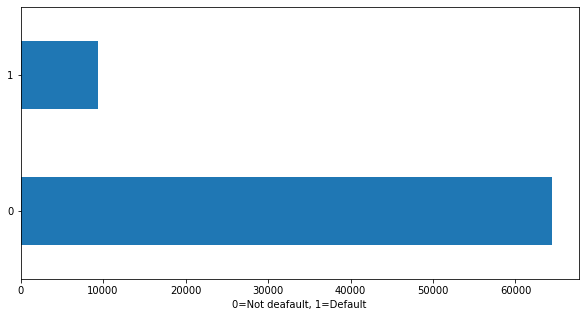

In [544]:
plt.figure(figsize=(10, 5))
df_train.default.value_counts().plot.barh()
plt.xlabel('0=Not deafault, 1=Default')

In [545]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных.

- Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:

Text(0, 0.5, 'Образование')

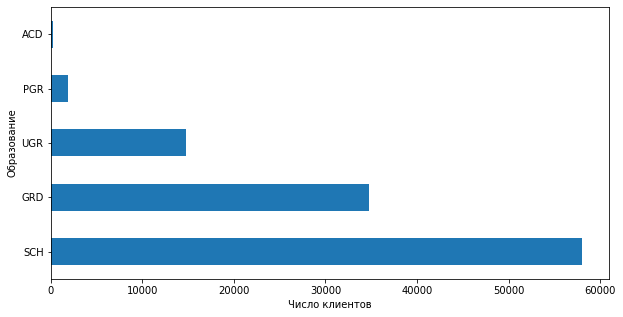

In [546]:
plt.figure(figsize=(10, 5))
df.education.value_counts().plot.barh()
plt.xlabel('Число клиентов')
plt.ylabel('Образование')

А теперь заполним пропуски в поле 'education'.

In [547]:
df.education.describe()

count     109670
unique         5
top          SCH
freq       57998
Name: education, dtype: object

Признак 'образование' содержит 5 уникальных значений.

In [548]:
df.education.isnull().sum()

478

Посчитаем процент пропусков.

In [549]:
print('Пропуски признака education у {} % данных'.format(df['education'].isnull().sum()/len(df.education)*100))

Пропуски признака education у 0.4339615789664814 % данных


Заполним 478 пропусков у признака 'education' ( а это меньше 0.5% от общего числа строк) модой, то есть самым часто встречающимся значением, а именно, 'SCH'.

In [550]:
df = df.fillna('SCH')

In [551]:
#Посмотрим пропущенные значения
df.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

In [552]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


- Посмотрим на признак 'foreign_passport'.

In [553]:
df.foreign_passport.value_counts()

N    93721
Y    16427
Name: foreign_passport, dtype: int64

Text(0.5, 1.0, 'Наличие заграничного паспорта. Y - есть, N - нет')

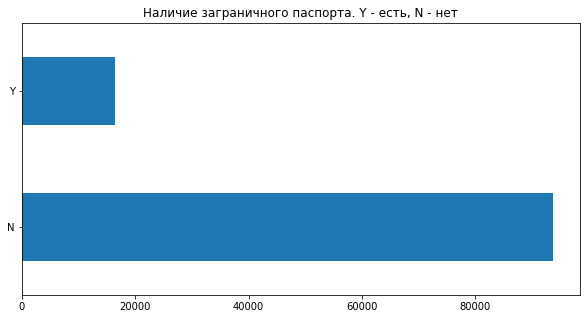

In [554]:
plt.figure(figsize=(10, 5))
df.foreign_passport.value_counts().plot.barh()
plt.title('Наличие заграничного паспорта. Y - есть, N - нет')


Людей, которые не имеют загранпаспорт существенно меньше.

- Рассмотрим признак client_id.

Посмотрим количество пропущенных значений.

In [555]:
df.client_id.isna().sum()

0

Пропуски отсутствуют, значения столбца уникальны. Смысла для анализа данных он не имеет. Понадобится только в Submission.

- Рассмотрим столбец app_date

In [556]:
#Преобразуем в datetime
df['app_cld'] = pd.to_datetime(df.app_date, format='%d%b%Y')
df['app_cld'].describe()

count                  110148
unique                    120
top       2014-03-18 00:00:00
freq                     1491
first     2014-01-01 00:00:00
last      2014-04-30 00:00:00
Name: app_cld, dtype: object

Отсюда видно, что в датасете есть данне за 4 месяца, а именно, за январь - апрель, включительно.


Посмотрим распределение по месяцам.

Text(0.5, 1.0, 'Распределение по месяцам')

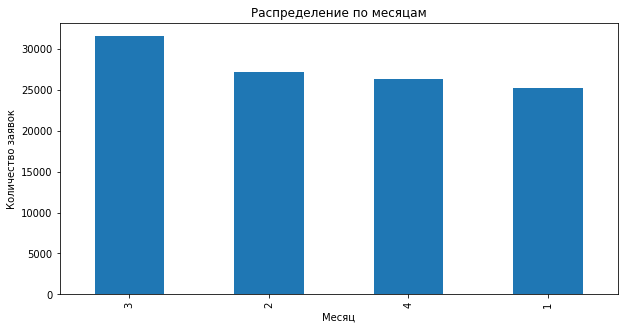

In [557]:
plt.figure(figsize=(10, 5))
df['app_cld'].dt.month.value_counts().plot(kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Количество заявок')
plt.title('Распределение по месяцам')

Видно, что в марте заявок больше, чем в другие месяцы.

Посмотрим, как ведет себя график по дням недели. 

Text(0.5, 1.0, 'Распределение по неделям')

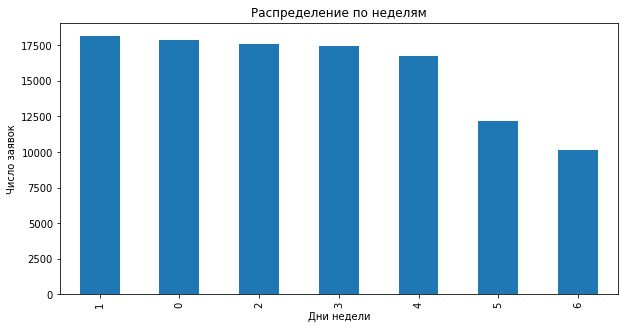

In [558]:
plt.figure(figsize=(10, 5))
df['app_day'] = df['app_cld'].apply(lambda x: datetime.weekday(x))
df['app_day'].value_counts().plot(kind='bar')
plt.xlabel('Дни недели')
plt.ylabel('Число заявок')
plt.title('Распределение по неделям')

В будние дни заявок больше, чем в выходные.
Значит, можно добавить столбец с месяцами и удалить признаки app_date и app_cld.

In [559]:
df['app_mth'] = df['app_cld'].dt.month
df['app_mth'].value_counts() #добавляем столбец с разбивкой по месяцам
df.drop(['app_date', 'app_cld'], axis='columns', inplace=True) #удаляем 

In [560]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_day,app_mth
0,74835,GRD,M,29,Y,Y,0,0,-2.271884,3,...,1,2,50000,1,4,N,0,0,5,3
1,17527,SCH,F,39,N,N,5,0,-1.504999,2,...,1,2,5000,4,3,N,0,0,4,1
2,75683,UGR,M,50,Y,Y,0,0,-1.691339,1,...,1,2,30000,1,3,Y,0,0,6,3
3,26883,SCH,M,56,N,N,0,0,-2.374182,1,...,1,2,17000,1,3,N,0,0,0,2
4,28862,GRD,F,38,N,N,0,0,-2.487502,0,...,2,3,120000,1,3,N,0,0,1,2


In [561]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

#### Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [562]:
df.nunique() #уникальные значения каждого признака

client_id           110148
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
app_day                  7
app_mth                  4
dtype: int64

In [563]:
#бинарные переменные - 5
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
#категориальные переменные - 7
cat_cols = ['education', 'home_address', 'work_address','region_rating', 'sna','first_time', 'app_mth', 'app_day']
#числовые переменные - 6
num_cols = ['age', 'decline_app_cnt','bki_request_cnt', 'income', 'score_bki']

На диаграмме для переменной 'default' видно ,что клиентов банка без дефолта существено больше, чем тех, у кого есть дефолт.

Для того чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. Тогда можно избежать чувствительности к сильным отклонениям в суммах у линейных моделей. Построим графики распределения логарифмированных переменных.

### Посмотрим на распределение числовых данных:

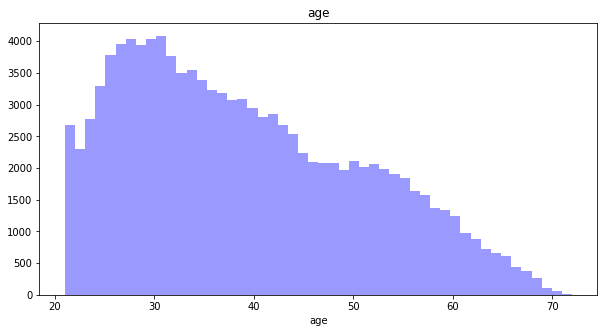

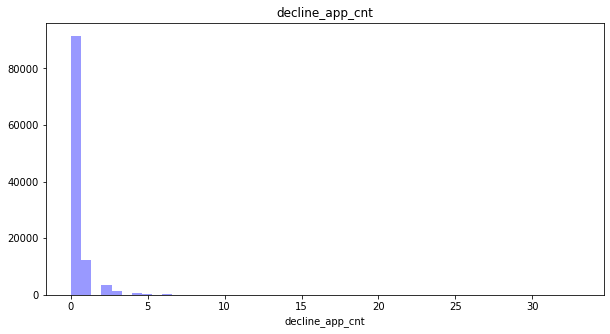

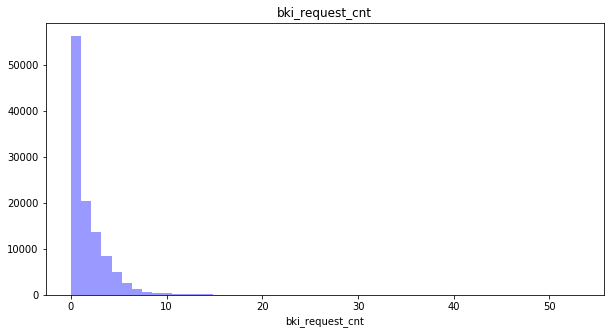

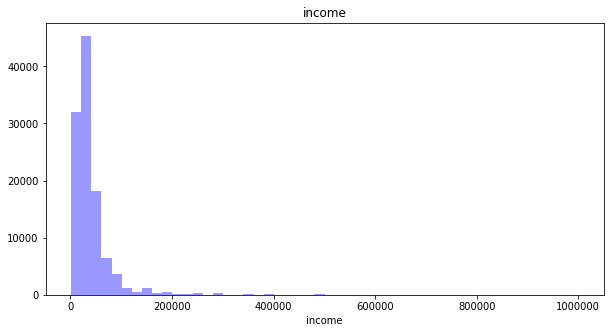

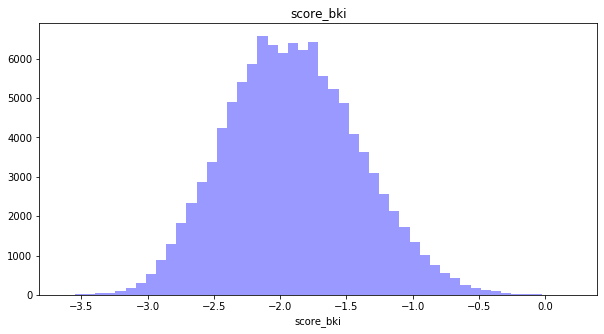

In [564]:
for i in df[num_cols]:
    plt.figure(figsize=(10,5))
    sns.distplot(df[i], kde = False, color='b')
    plt.title(i)
    plt.show()

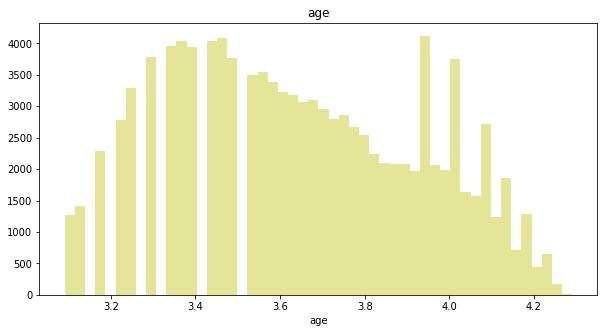

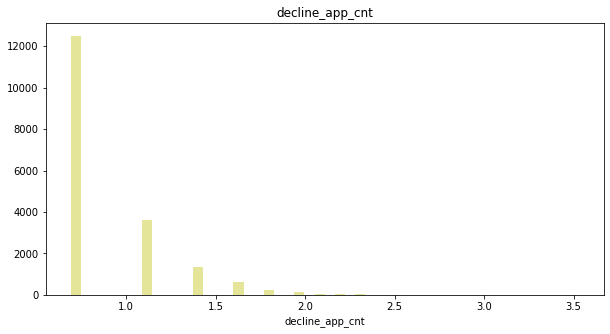

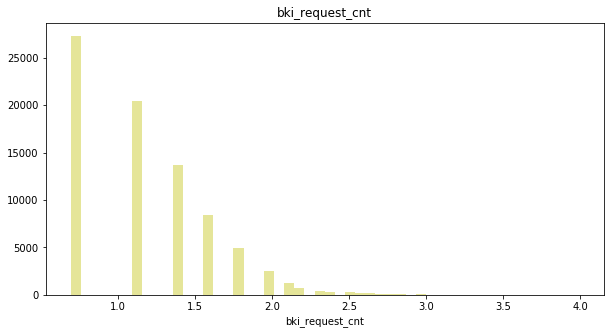

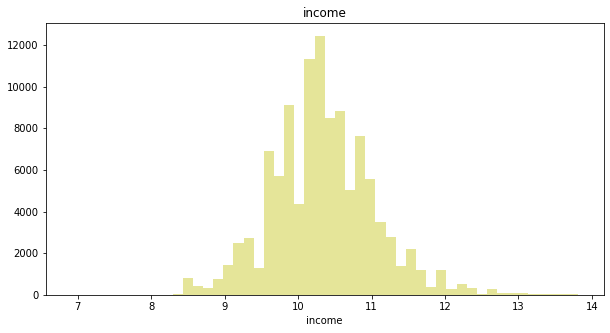

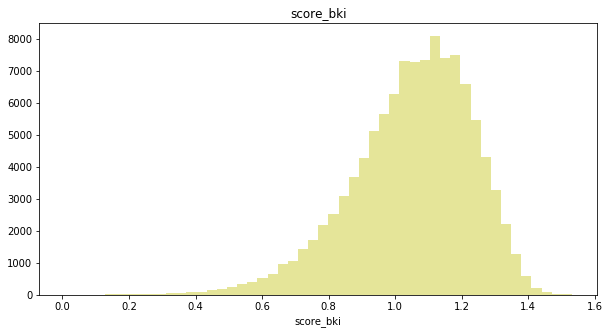

In [565]:
# Преобразуем все числовые переменные в логарифмические функции
for i in num_cols:
    df[i] = np.log1p(df[i].abs())
    plt.figure(figsize=(10,5))
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False, color='y')
    plt.title(i)
    plt.show()

Отлично! Некоторые переменные стали менее смещёнными.

Такой принцип можно применить перед построением модели и сравнить значение метрики.

Добавим логарифмированные числовые признаки в датасет. Но предварительно посмотрим, количество выбросов до логарифмирования и после него.

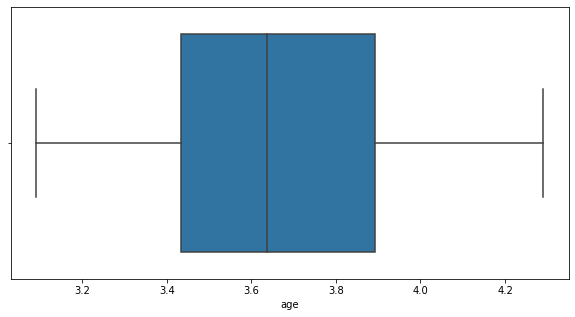

In [566]:
plt.figure(figsize=(10, 5))
sns.boxplot(x = 'age', data = df) 

In [567]:
statistic('age')

Для age IQR: 0.4578330936254802,  Границы выбросов: [2.7472375640469258, 4.5785699385488465].
Всего 0 выбросов


Выбросов нет. И ранее видели, что график после логарифмирования сглаживается. Поэтому добавляем логарифм возраста в датасет.

In [568]:
df['age_log'] = np.log(df['age'] + 1)
df['age'] = df['age_log']
df.drop(['age_log'], axis = 1, inplace = True) 

Для того, чтобы появилась возможность логарифмировать score_bki, сделаем данные положительными.

In [569]:
df['score_bki'] = df['score_bki'] + abs(df['score_bki'].min())
df['score_bki_log'] = np.log(df['score_bki'] + 1)

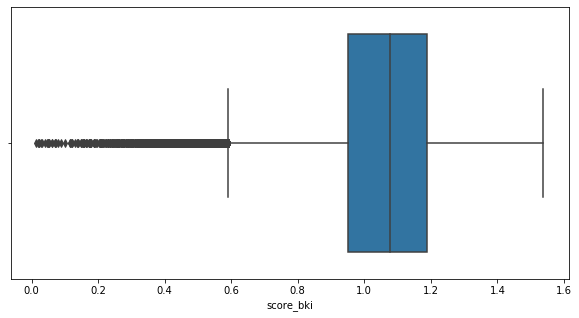

In [570]:
plt.figure(figsize=(10, 5))
sns.boxplot(x = 'score_bki', data = df) 

Посмотрим статистику - межквартильных размах и границы выбросов для нелогарифмированного признака и для логарифмированного, соответственно.

In [571]:
statistic('score_bki')
statistic('score_bki_log')

Для score_bki IQR: 0.23877638357857067,  Границы выбросов: [0.5917009772359867, 1.5468065115502694].
Всего 1777 выбросов
Для score_bki_log IQR: 0.11552080819303345,  Границы выбросов: [0.4944792105254807, 0.9565624432976145].
Всего 2657 выбросов


В итоге распределение сильно сместилось, а выбросов стало намного больше. Поэтому оставляем как есть.

In [572]:
df.drop(['score_bki_log'], axis=1, inplace=True) #Удаляем новый признак 

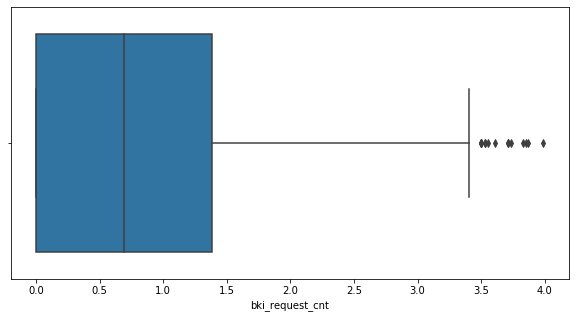

In [573]:
plt.figure(figsize=(10, 5))


df['bki_request_cnt_log'] = np.log(df['bki_request_cnt'] + 1)

sns.boxplot(x = 'bki_request_cnt', data = df) 


In [574]:
statistic('bki_request_cnt')
statistic('bki_request_cnt_log')

Для bki_request_cnt IQR: 1.3862943611198906,  Границы выбросов: [-2.0794415416798357, 3.465735902799726].
Всего 15 выбросов
Для bki_request_cnt_log IQR: 0.8697416861919439,  Границы выбросов: [-1.3046125292879158, 2.17435421547986].
Всего 0 выбросов


Количество выбросов существенно сократилось. Оставляем логарифмированный вариант

In [575]:
df['bki_request_cnt'] = df['bki_request_cnt_log']
df.drop(['bki_request_cnt_log'],axis=1, inplace=True)

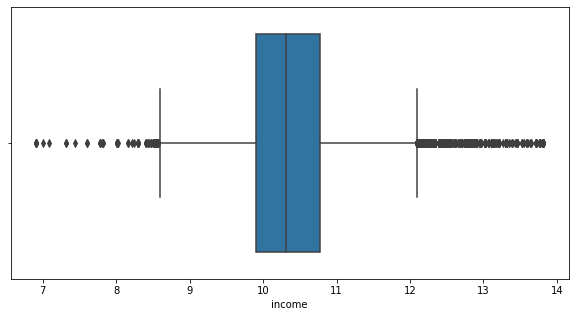

In [576]:
plt.figure(figsize=(10, 5))
sns.boxplot(x = 'income', data = df) 

In [577]:
df['income_log'] = np.log(df['income'] + 1)

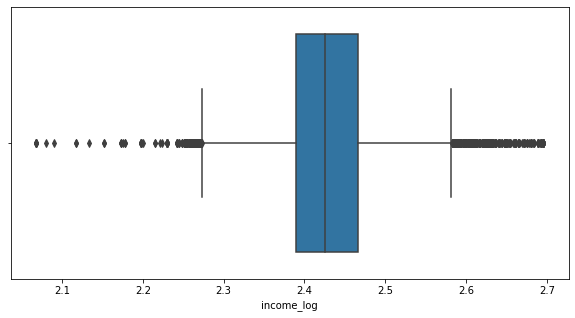

In [578]:
plt.figure(figsize=(10, 5))
sns.boxplot(x = 'income_log', data = df) 

In [579]:
statistic('income')
statistic('income_log')

Для income IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].
Всего 2609 выбросов
Для income_log IQR: 0.07722906021905862,  Границы выбросов: [2.273243692242409, 2.5821599331186436].
Всего 2328 выбросов


Итак, выбросов стало меньше. Поэтому оставим в датасете логарифмированный признак income.


In [580]:
df['income'] = df['income_log']
df.drop(['income_log'], axis=1, inplace = True)

 - Построим boxplot’ы для численных в  переменных в зависимости от "дефолтности" клиента.

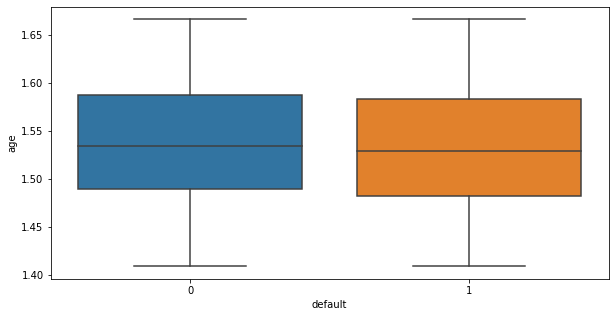

In [581]:
plt.figure(figsize=(10, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_ylim(1.4, 1.7)
sns.boxplot(x = 'default', y = 'age', data = df)

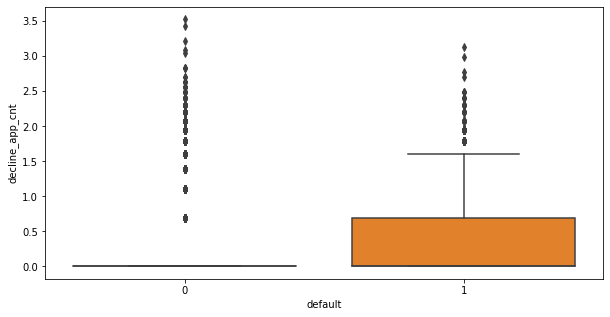

In [582]:
plt.figure(figsize=(10, 5))
axes = fig.add_axes([0, 0, 1, 2])
axes.set_ylim(0, 2)
sns.boxplot(x = 'default', y = 'decline_app_cnt', data = df)

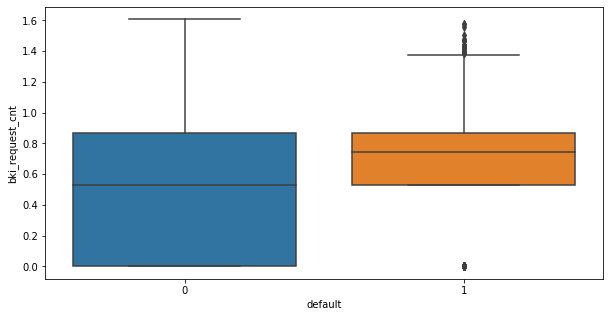

In [583]:
plt.figure(figsize=(10, 5))

axes = fig.add_axes([0, 0, 1, 2])
axes.set_ylim(0, )
sns.boxplot(x = 'default', y = 'bki_request_cnt', data= df)


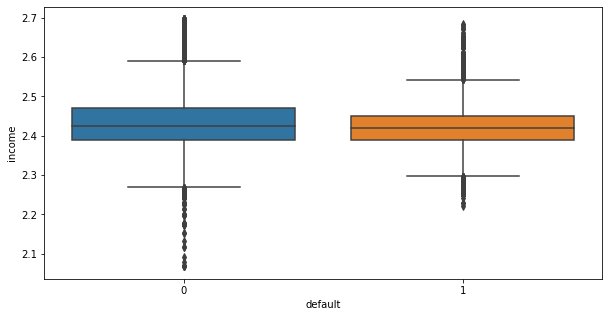

In [584]:
plt.figure(figsize=(10, 5))

axes = fig.add_axes([0, 0, 1, 2])
axes.set_ylim(0,60000)
sns.boxplot(x = 'default', y = 'income', data = df)

Выводы такие:
 - дефолтные клиенты в среднем немного младше
 - дефолтные клиенты в среднем имеют большое количество отмененных заявок
 - дефолтные клиенты в среднем имеют больше запросов в БКИ
 - Дефолтные клиенты в среднем имеют более низкий доход

Cильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.
Как работать с корреляцией? 

→ Способ 1. Отобрать низко коррелируемые признаки .

→ Способ 2. Использовать регуляризацию, чтобы в процессе обучения штрафовать модель за сложность, выраженную в величине весов, при этом задавая величину штрафа. Изменяя эту величину, я смогу контролировать переобучение и устойчивость модели. 

Но начнём с простого...

Оценим корреляцию Пирсона для численных переменных по формуле:

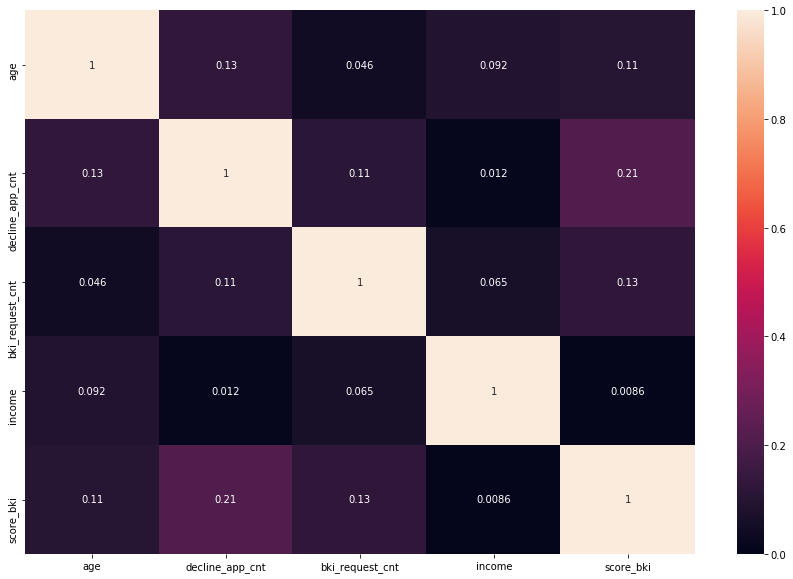

In [585]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)


In [586]:
df[num_cols].corr()

,age,decline_app_cnt,bki_request_cnt,income,score_bki
age,1.000000,-0.129905,0.045661,-0.092093,0.105424
decline_app_cnt,-0.129905,1.000000,0.109532,-0.011885,-0.210521
bki_request_cnt,0.045661,0.109532,1.000000,0.065499,-0.125203
income,-0.092093,-0.011885,0.065499,1.000000,-0.008643
score_bki,0.105424,-0.210521,-0.125203,-0.008643,1.000000


1. Положительно скоррелированны признаки 'число запросов в БКИ' и 'количество отказанных прошлых заявок'. То есть, чем больше клиенту отказывают в получении кредита, тем больше он пытается подать запрос на новый кредит. 
2. Следующая по значимости корреляция между признаками 'доход' и 'число запросов в БКИ', соответственно, чем больше доход у человека, тем вероятнее от обращается за кредитом. 
3. Последняя значимая положительная корреляция между признаками 'возраст' и 'число запросов в БКИ'. То есть люди постарше обращаются за кредитом немного чаще. 
4. Остальные признаки скоррелированны слабо и отрицательно. 
5. Существенных сильных корреляций нет. 



#### Как мы видим, взаимосвязь пар числовых признаков по Пирсону слабая. Это очень здорово для нашей линейной модели!

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 


В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.



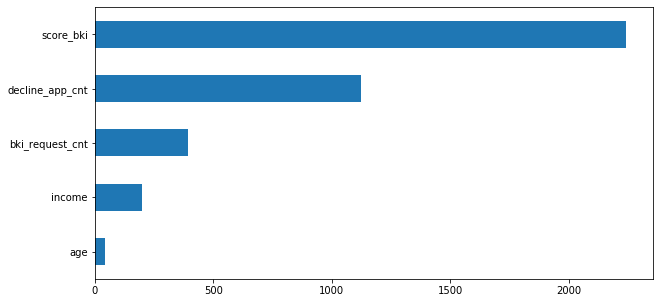

In [587]:
plt.figure(figsize=(10, 5))
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Категориальные переменные

In [588]:
path_to_data = '/Users/oabazhanova/Documents/Python/unit_3/sf-dst-scoring/'

# Импорт и просмотр данных
df_train = pd.read_csv(path_to_data+'train.csv')
df_test = pd.read_csv(path_to_data+'test.csv')
sample_submission = pd.read_csv(path_to_data+'/sample_submission.csv')

print('df_train: ', df_train.shape)
display(df_train.head())

df_train:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Самый простой способ — отобразить каждое значение категории в уникальное число. Например, в поле sex значение sex = female преобразовать в 0, а sex = male — в 1. Эту простую операцию приходится делать достаточно часто, поэтому в модуле sklearn.preprocessing именно для этой задачи реализован класс LabelEncoder.

Метод fit этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод transform непосредственно преобразует значения в числа. После fit у label_encoder будет доступно поле classes_, содержащее все уникальные значения. Можно их пронумеровать и убедиться, что преобразование выполнено верно.

In [589]:
# Для бинарных признаков используем LabelEncoder
map_categories = {}  # Создаём словарь кодировок

label_encoder = LabelEncoder()

for column in bin_cols:  # Организуем цикл по бинарным признакам и формируем словарь
    df[column] = label_encoder.fit_transform(df[column])
    map_categories[column] = dict(enumerate(label_encoder.classes_)) # Запоминаем, что закодировали

In [590]:
map_categories

{'sex': {0: 'F', 1: 'M'},
 'car': {0: 'N', 1: 'Y'},
 'car_type': {0: 'N', 1: 'Y'},
 'good_work': {0: 0, 1: 1},
 'foreign_passport': {0: 'N', 1: 'Y'}}

Сработало! Теперь всегда можно обратиться к classes_ , если забыли, что закодировали. Применим LabelEncoder ко всему набору бинарных переменных.

ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

Поскольку mutual_info_classif сначала требует, чтобы категориальные значения были сопоставлены с целочисленными значениями, то придется преобразовать столбец 'education' в численные значения. 

Посмотрим, сколько уникальных значений содержит это признак:

In [591]:
df.education.value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [592]:
df.education.unique()

array(['GRD', 'SCH', 'UGR', 'PGR', 'ACD'], dtype=object)

Уникальных значений 5. Они такие: 'SCH', 'GRD', 'UGR', 'PGR', 'ACD'.
Создадим словарь, и сопоставим этим категориальным значениям значения от 0 до 4 с помощью LabelEncoder.    

Для двух категориальных признаков: "education" и "region_rating" первоначально используем LabelEncoder

In [593]:
for name in ['education']:
    df[name] = label_encoder.fit_transform(df[name])
    map_categories[name] = dict(enumerate(label_encoder.classes_)) # Запоминаем, что закодировали

Проверяем словарь

In [594]:
map_categories

{'sex': {0: 'F', 1: 'M'},
 'car': {0: 'N', 1: 'Y'},
 'car_type': {0: 'N', 1: 'Y'},
 'good_work': {0: 0, 1: 1},
 'foreign_passport': {0: 'N', 1: 'Y'},
 'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}}

In [595]:
df.head() #Убеждаемся в преобразовании признаков

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_day,app_mth
0,74835,1,1,1.481877,1,1,0.000000,0,1.192148,0.869742,...,1,2,2.469776,1,4,0,0,0,5,3
1,17527,3,0,1.545194,0,0,1.791759,0,0.925070,0.741276,...,1,2,2.253121,4,3,0,0,0,4,1
2,75683,4,1,1.595709,1,1,0.000000,0,0.996821,0.526589,...,1,2,2.425598,1,3,1,0,0,6,3
3,26883,3,1,1.618011,0,0,0.000000,0,1.222935,0.526589,...,1,2,2.374071,1,3,0,0,0,0,2
4,28862,1,0,1.539779,0,0,0.000000,0,1.255968,0.000000,...,2,3,2.541228,1,3,0,0,0,1,2


А теперь посмотрим на значимость категориальных и бинарных признаков.

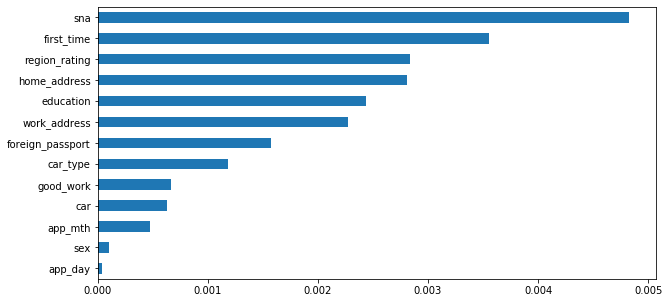

In [596]:
plt.figure(figsize=(10, 5))

imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

! Выводы:
Из категориальных признаков самыми значимыми являются признаки "sna" (связь заемщика с клиентами банка) и "first_time" (давность наличия информации о заемщике), наименее значимыми - "sex" (пол заёмщика), а так же неделя подачи заявки.

#### Посмотрим зависимости между признаками

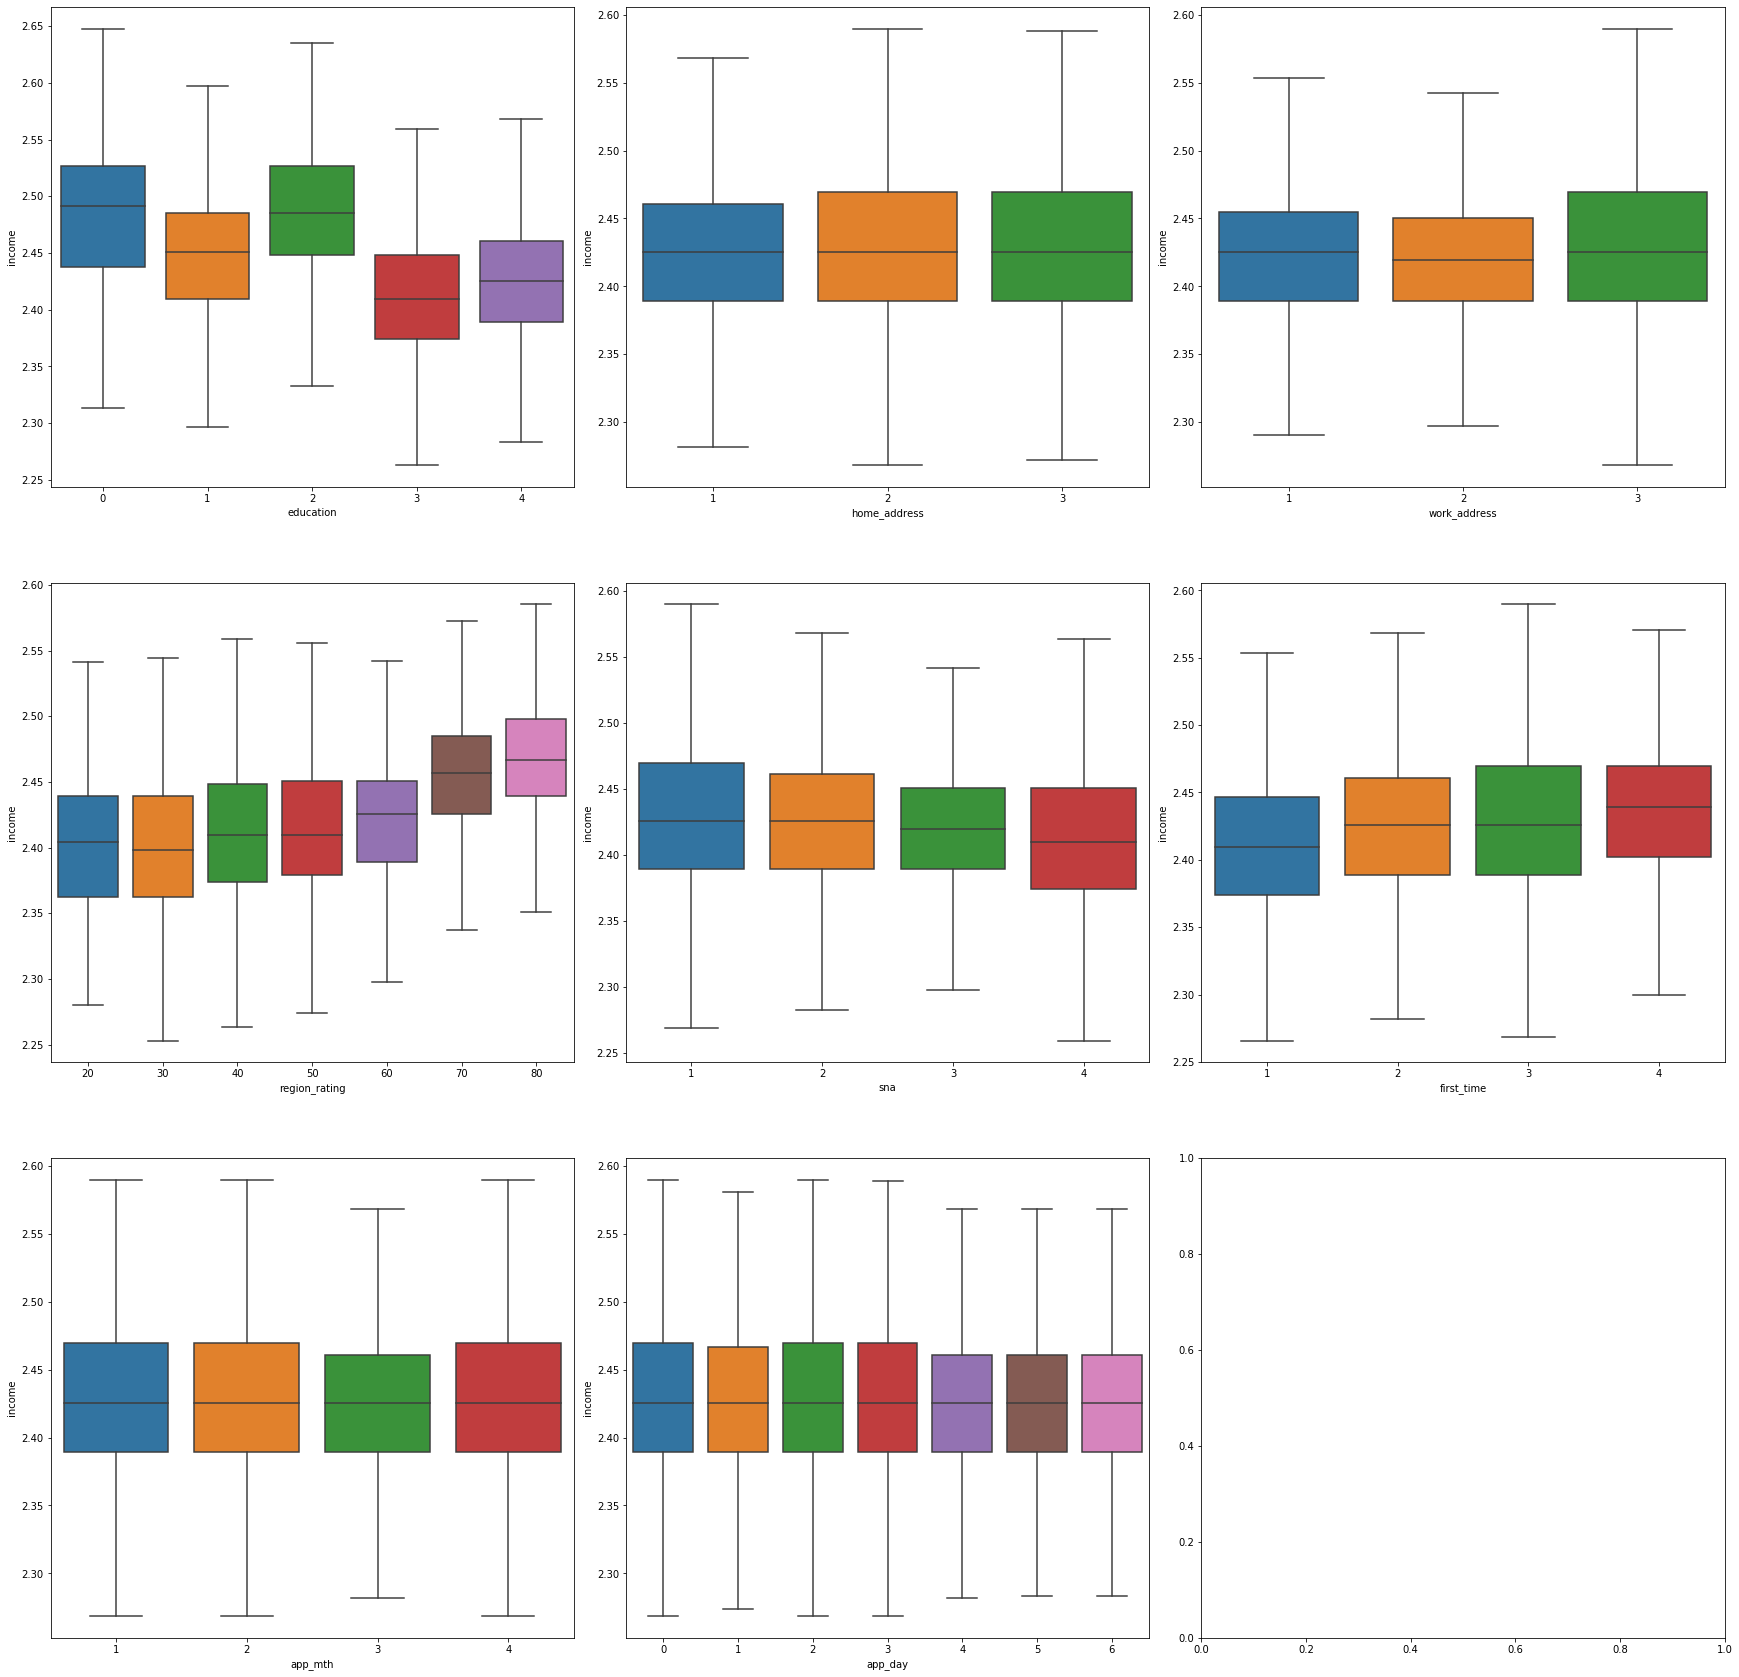

In [629]:
# Зависимость уровень дохода (income) от категориальных признаков.
fig, axes = plt.subplots(3, 3, figsize=(30,30))
plt.subplots_adjust(wspace = 0.1)
axes = axes.flatten()
for i in range(len(cat_cols)):
    sns.boxplot(x=cat_cols[i], y="income", data=df, orient = 'v', ax=axes[i], showfliers=False)

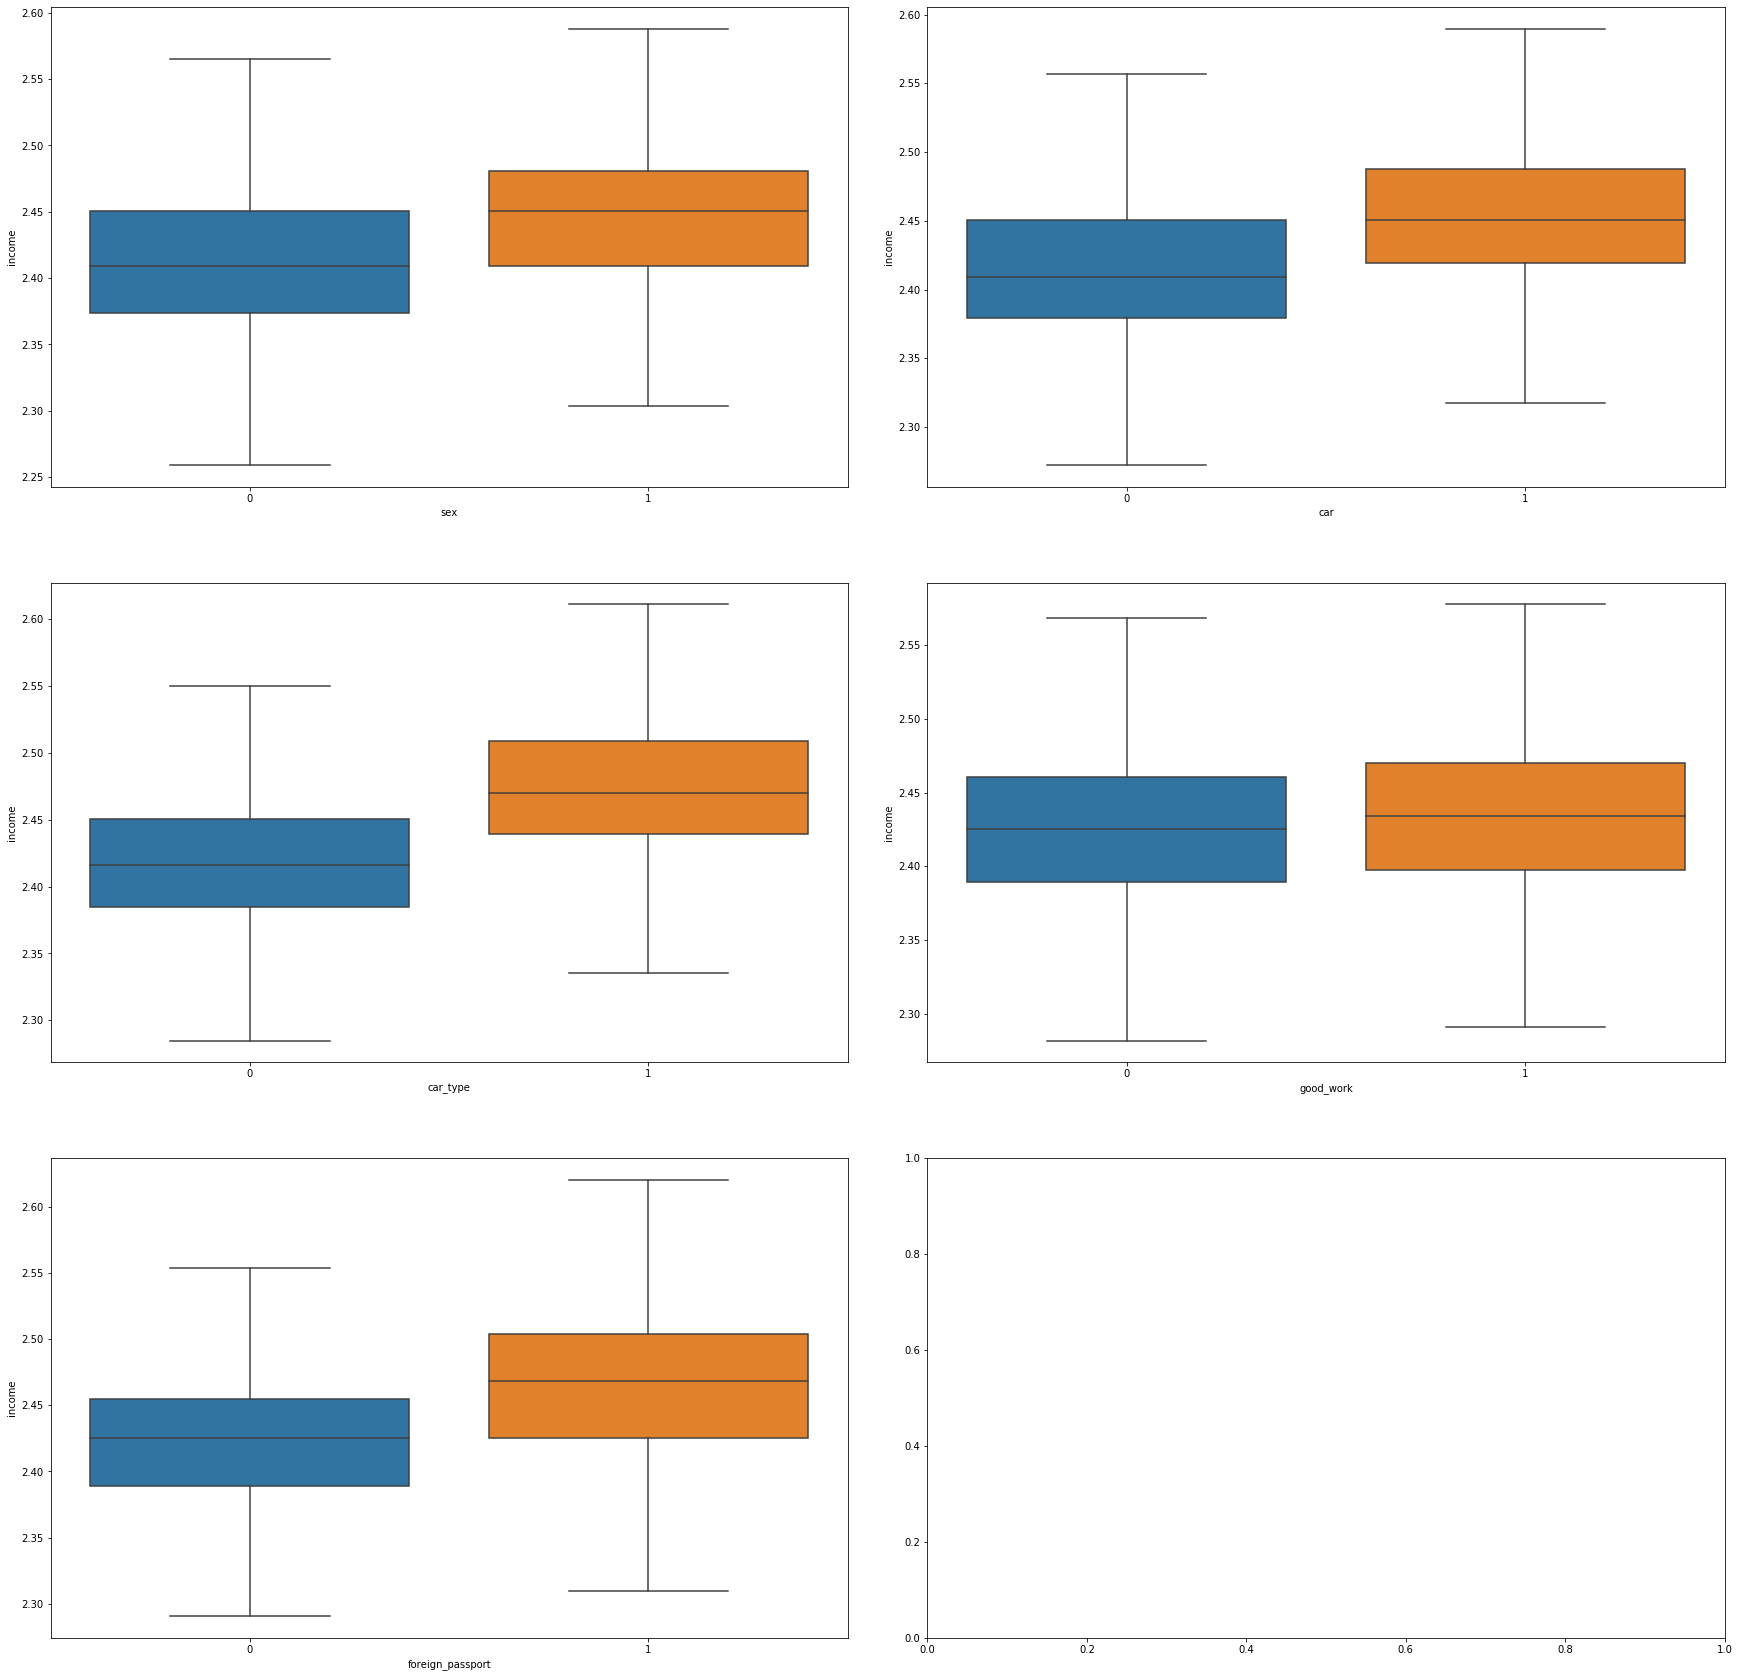

In [617]:
# Зависимость уровень дохода (income) от бинарных признаков.
fig, axes = plt.subplots(3, 2, figsize=(30,30))
plt.subplots_adjust(wspace = 0.1)
axes = axes.flatten()
for i in range(len(bin_cols)):
    sns.boxplot(x=bin_cols[i], y="income", data=df, orient = 'v', ax=axes[i], showfliers=False)

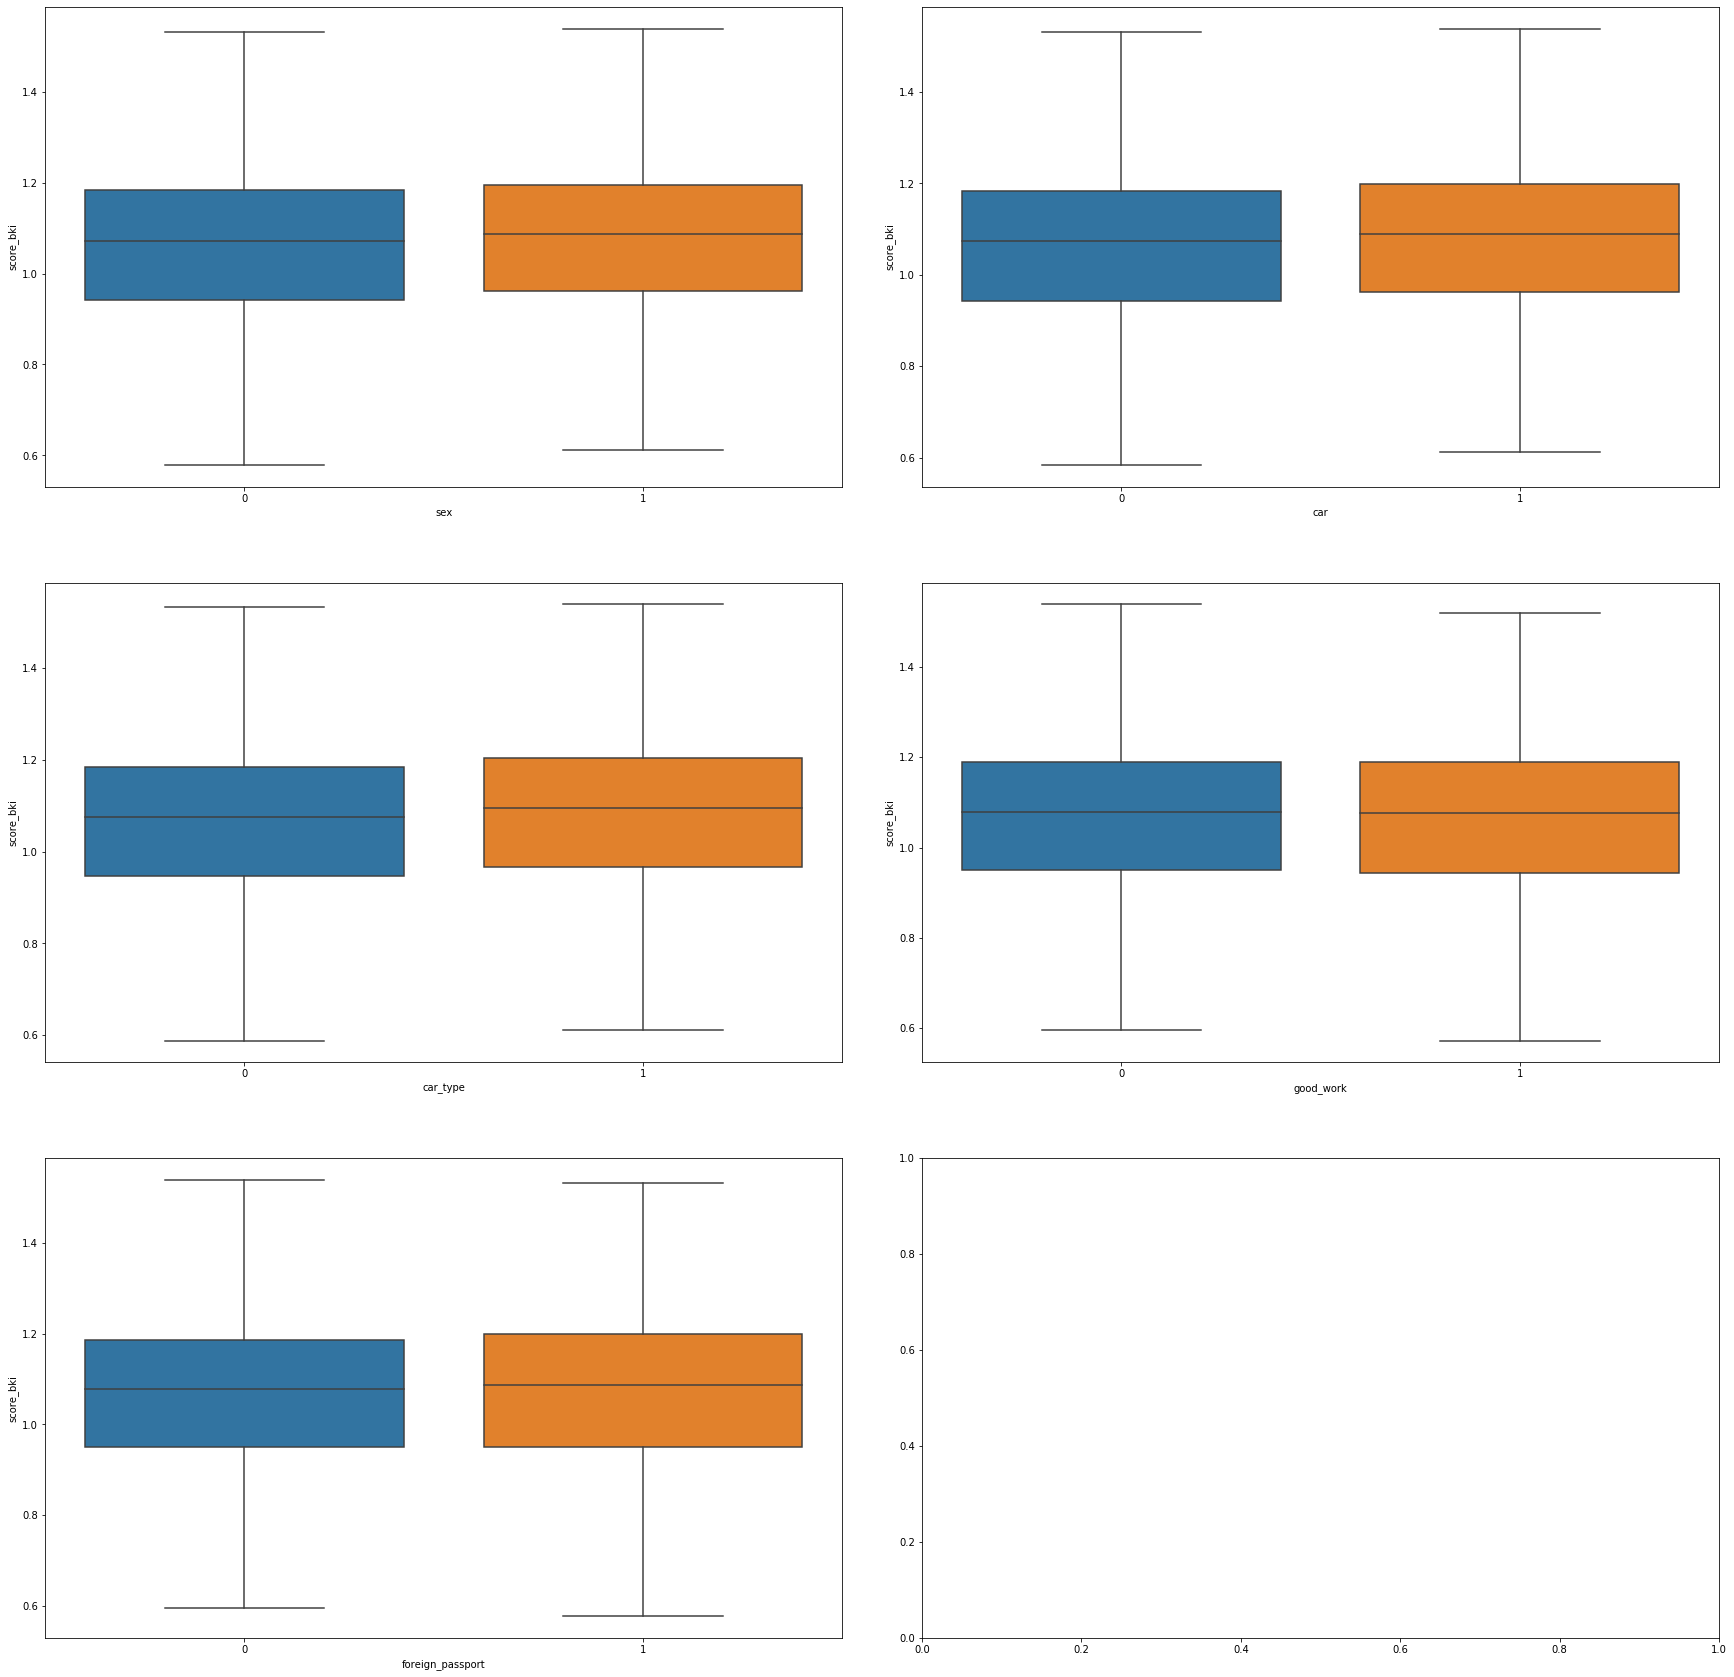

In [625]:
# Зависимость skoring (cкоринговый бал) от бинарных признаков.
fig, axes = plt.subplots(3,2, figsize=(30,30))
plt.subplots_adjust(wspace = 0.1)
axes = axes.flatten()
for i in range(len(bin_cols)):
    sns.boxplot(x=bin_cols[i], y="score_bki", data=df, orient = 'v', ax=axes[i], showfliers=False)

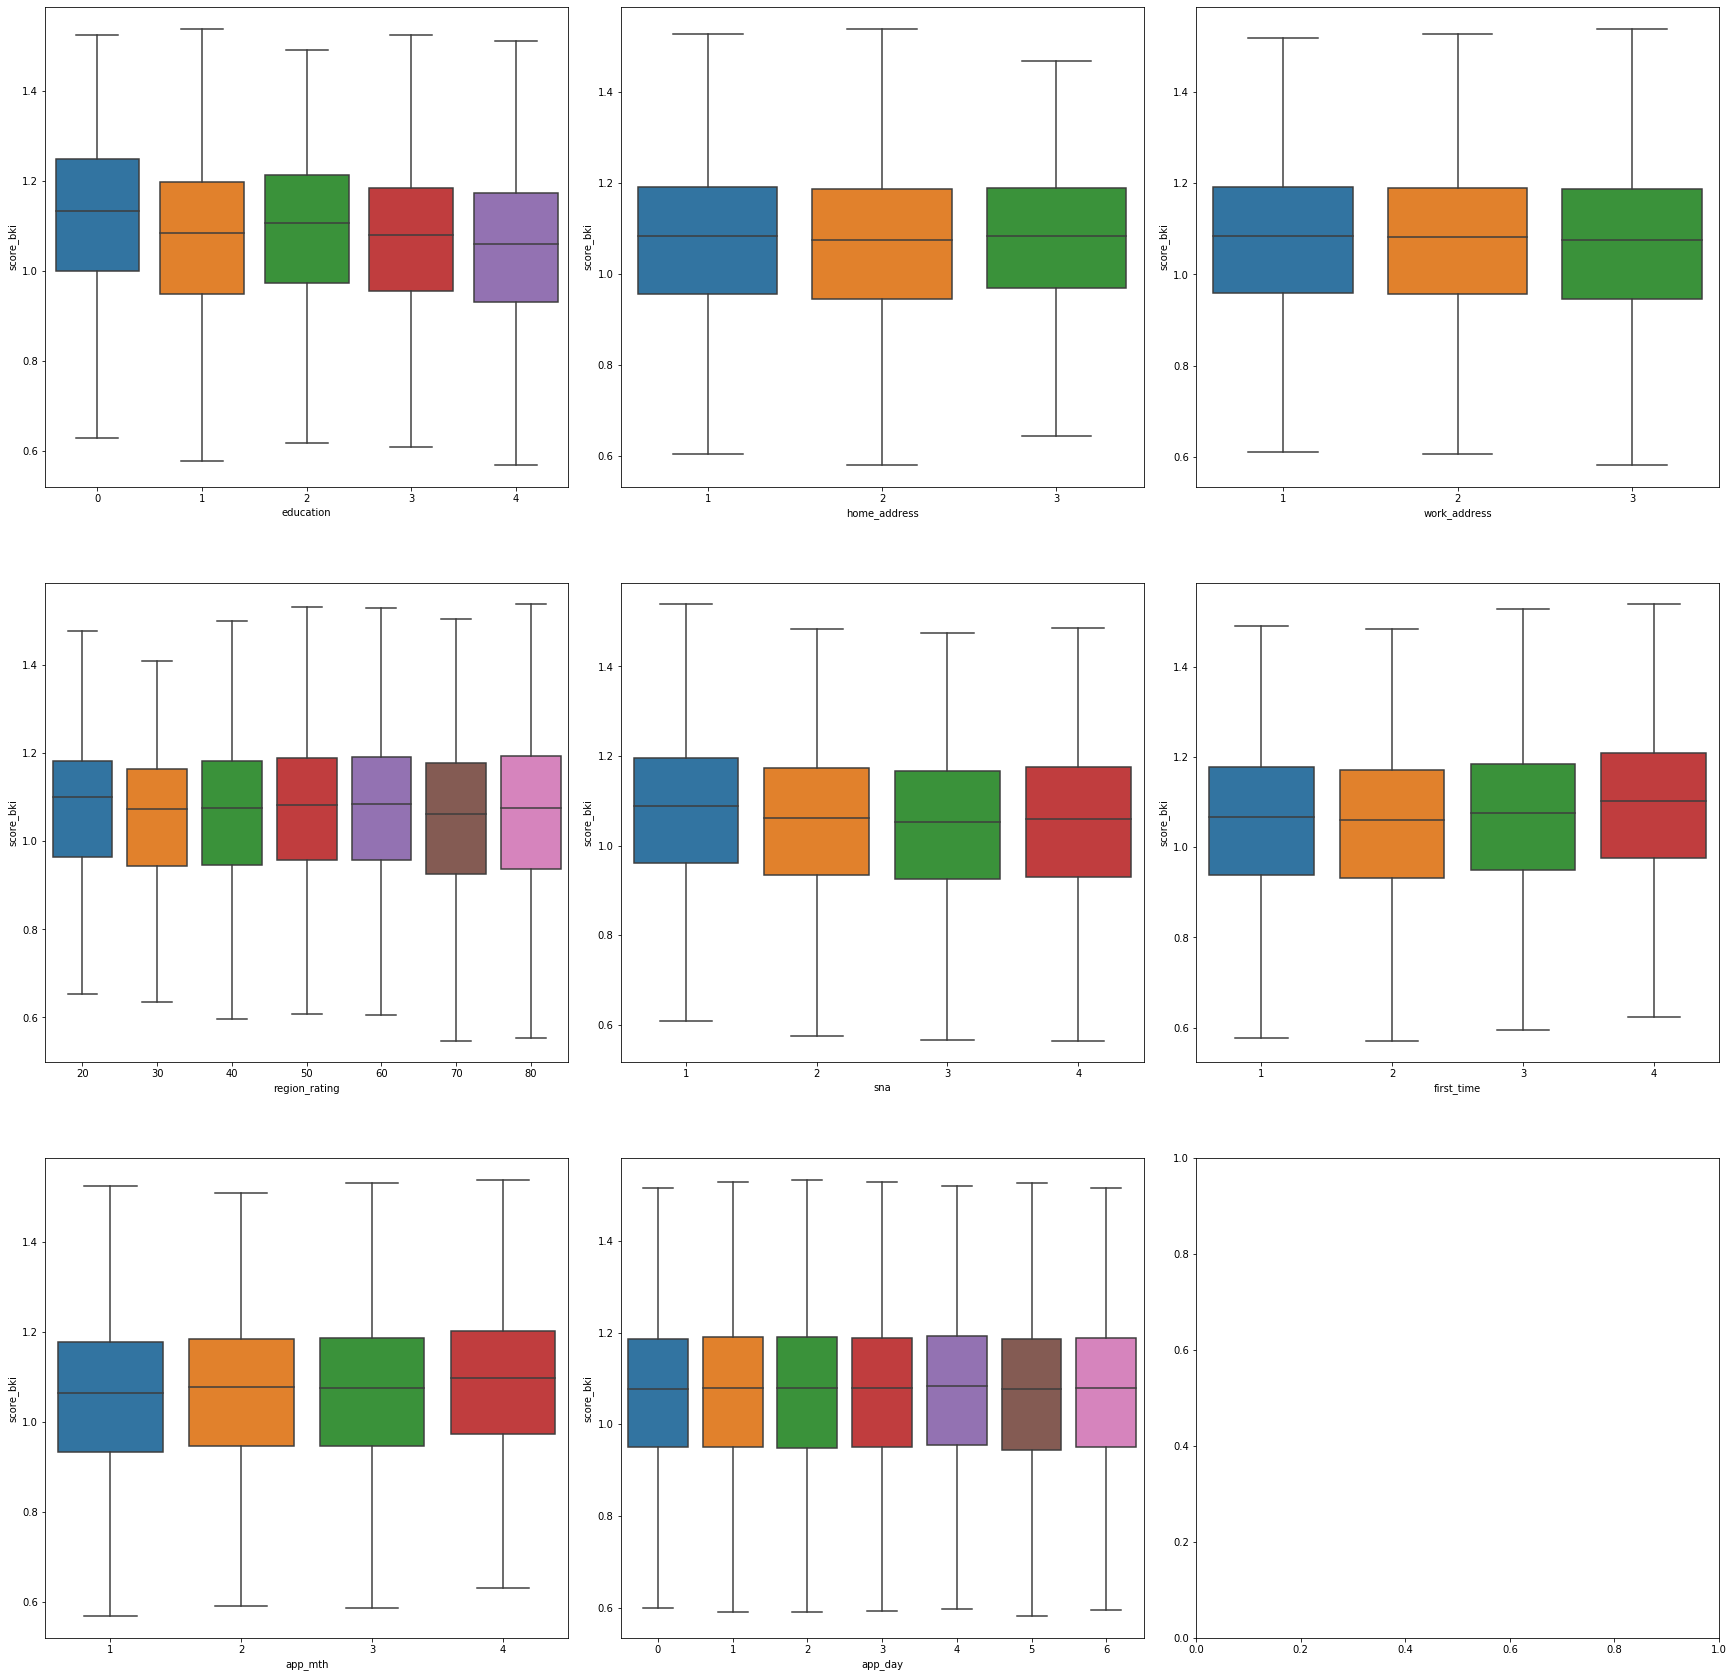

In [623]:
# Зависимость skoring (cкоринговый бал) от категориальных признаков.
fig, axes = plt.subplots(3,3, figsize=(30,30))
plt.subplots_adjust(wspace = 0.1)
axes = axes.flatten()
for i in range(len(cat_cols)):
    sns.boxplot(x=cat_cols[i], y="score_bki", data=df, orient = 'v', ax=axes[i], showfliers=False)

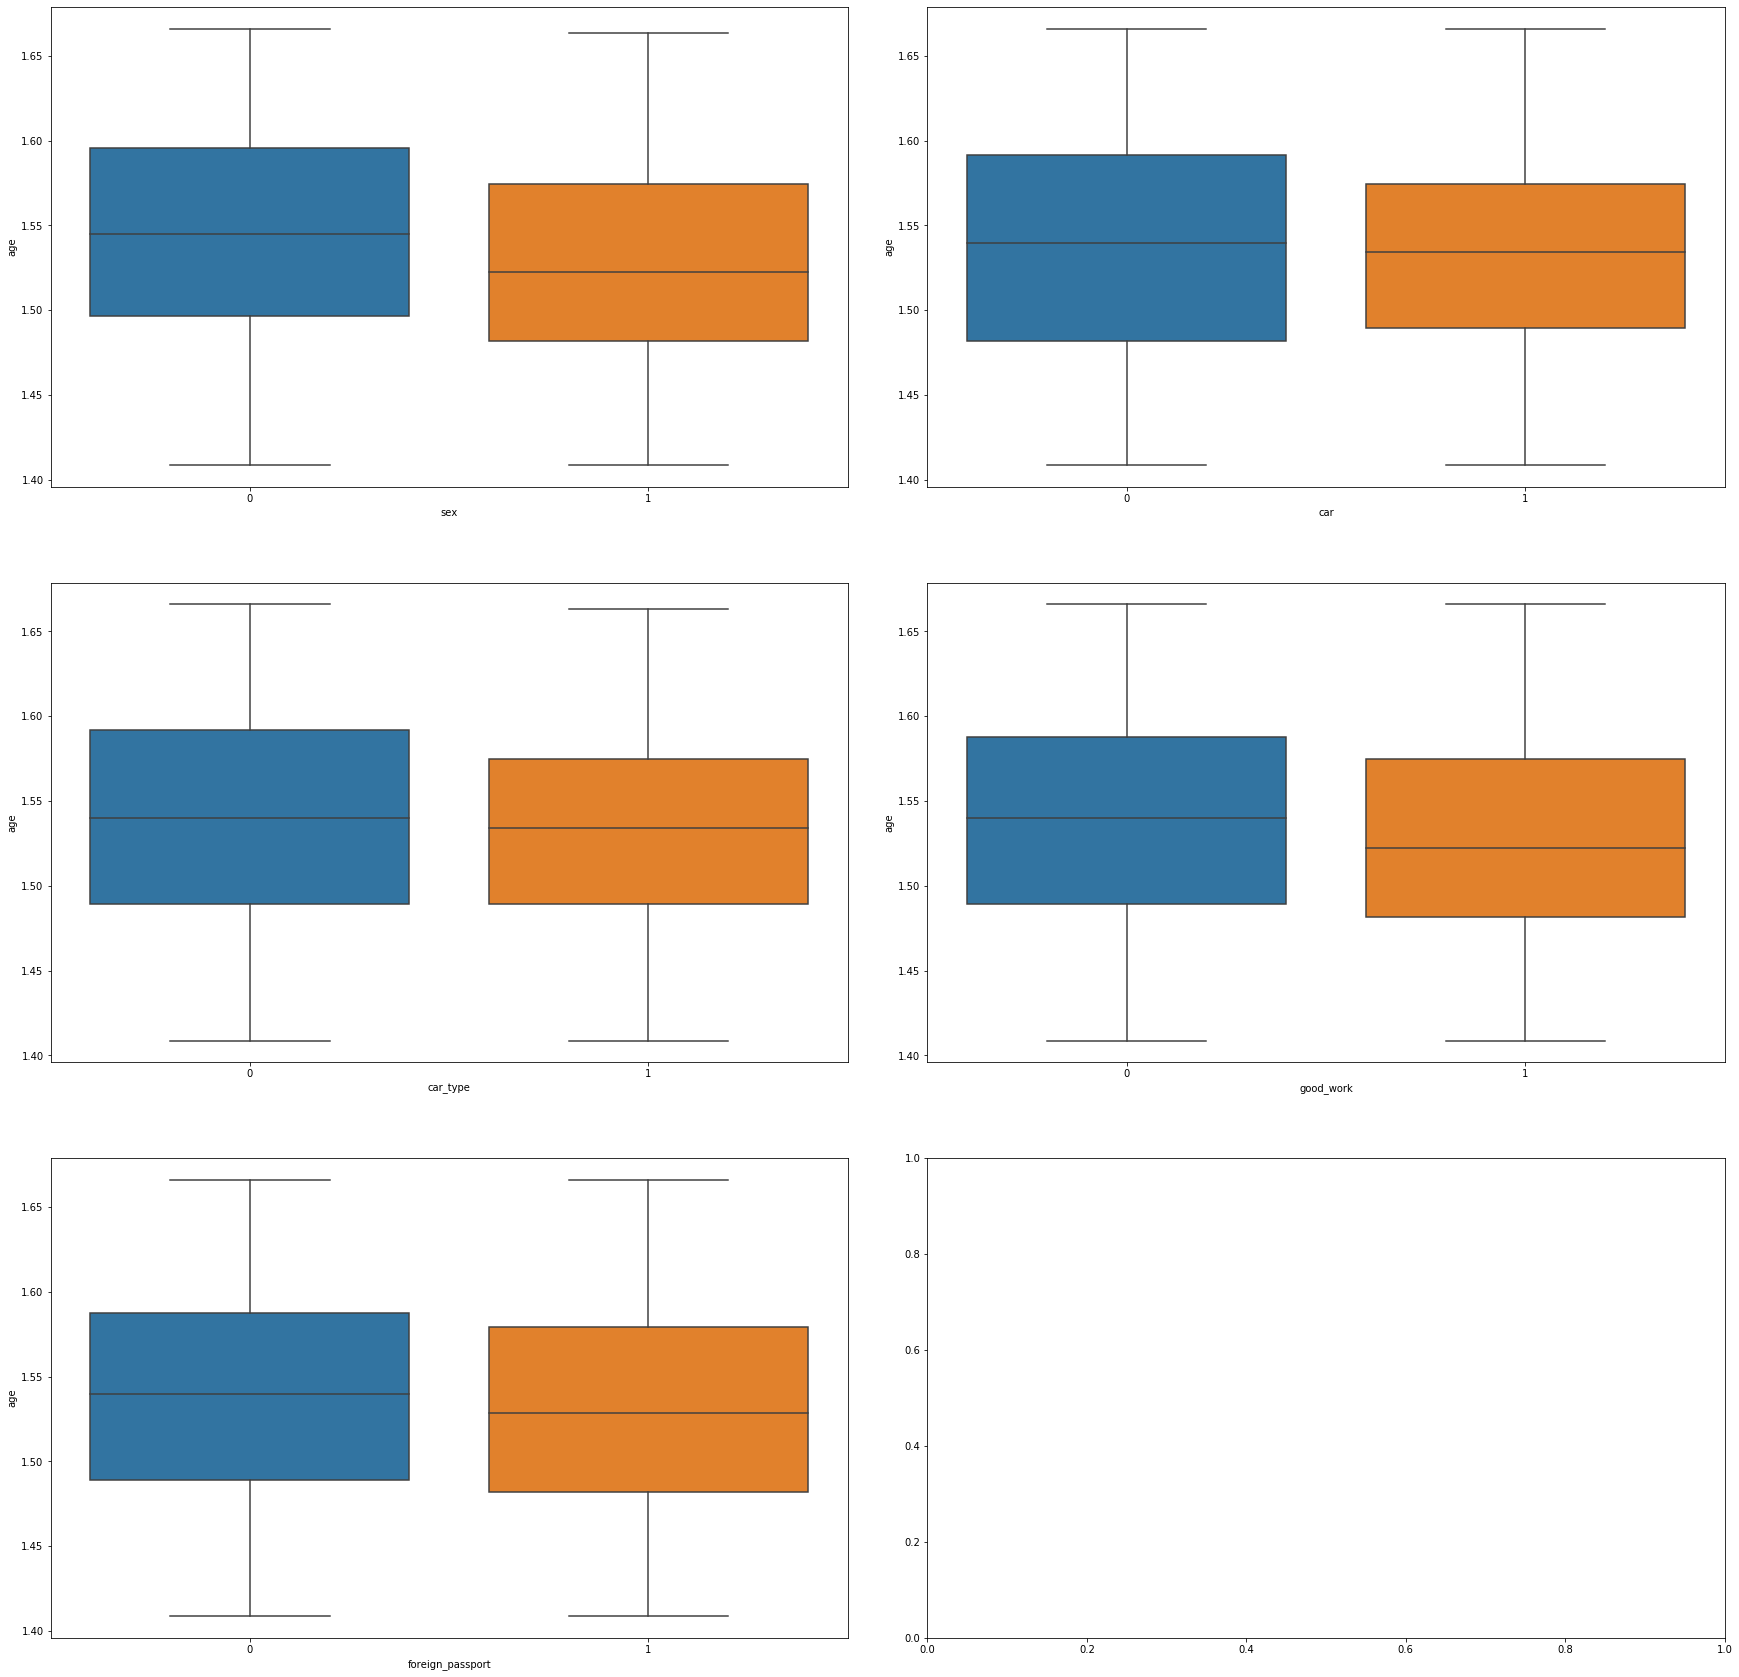

In [627]:
# Зависимость age (возраст) от бинарных признаков.
fig, axes = plt.subplots(3,2, figsize=(30,30))
plt.subplots_adjust(wspace = 0.1)
axes = axes.flatten()
for i in range(len(bin_cols)):
    sns.boxplot(x=bin_cols[i], y="age", data=df, orient = 'v', ax=axes[i], showfliers=False)

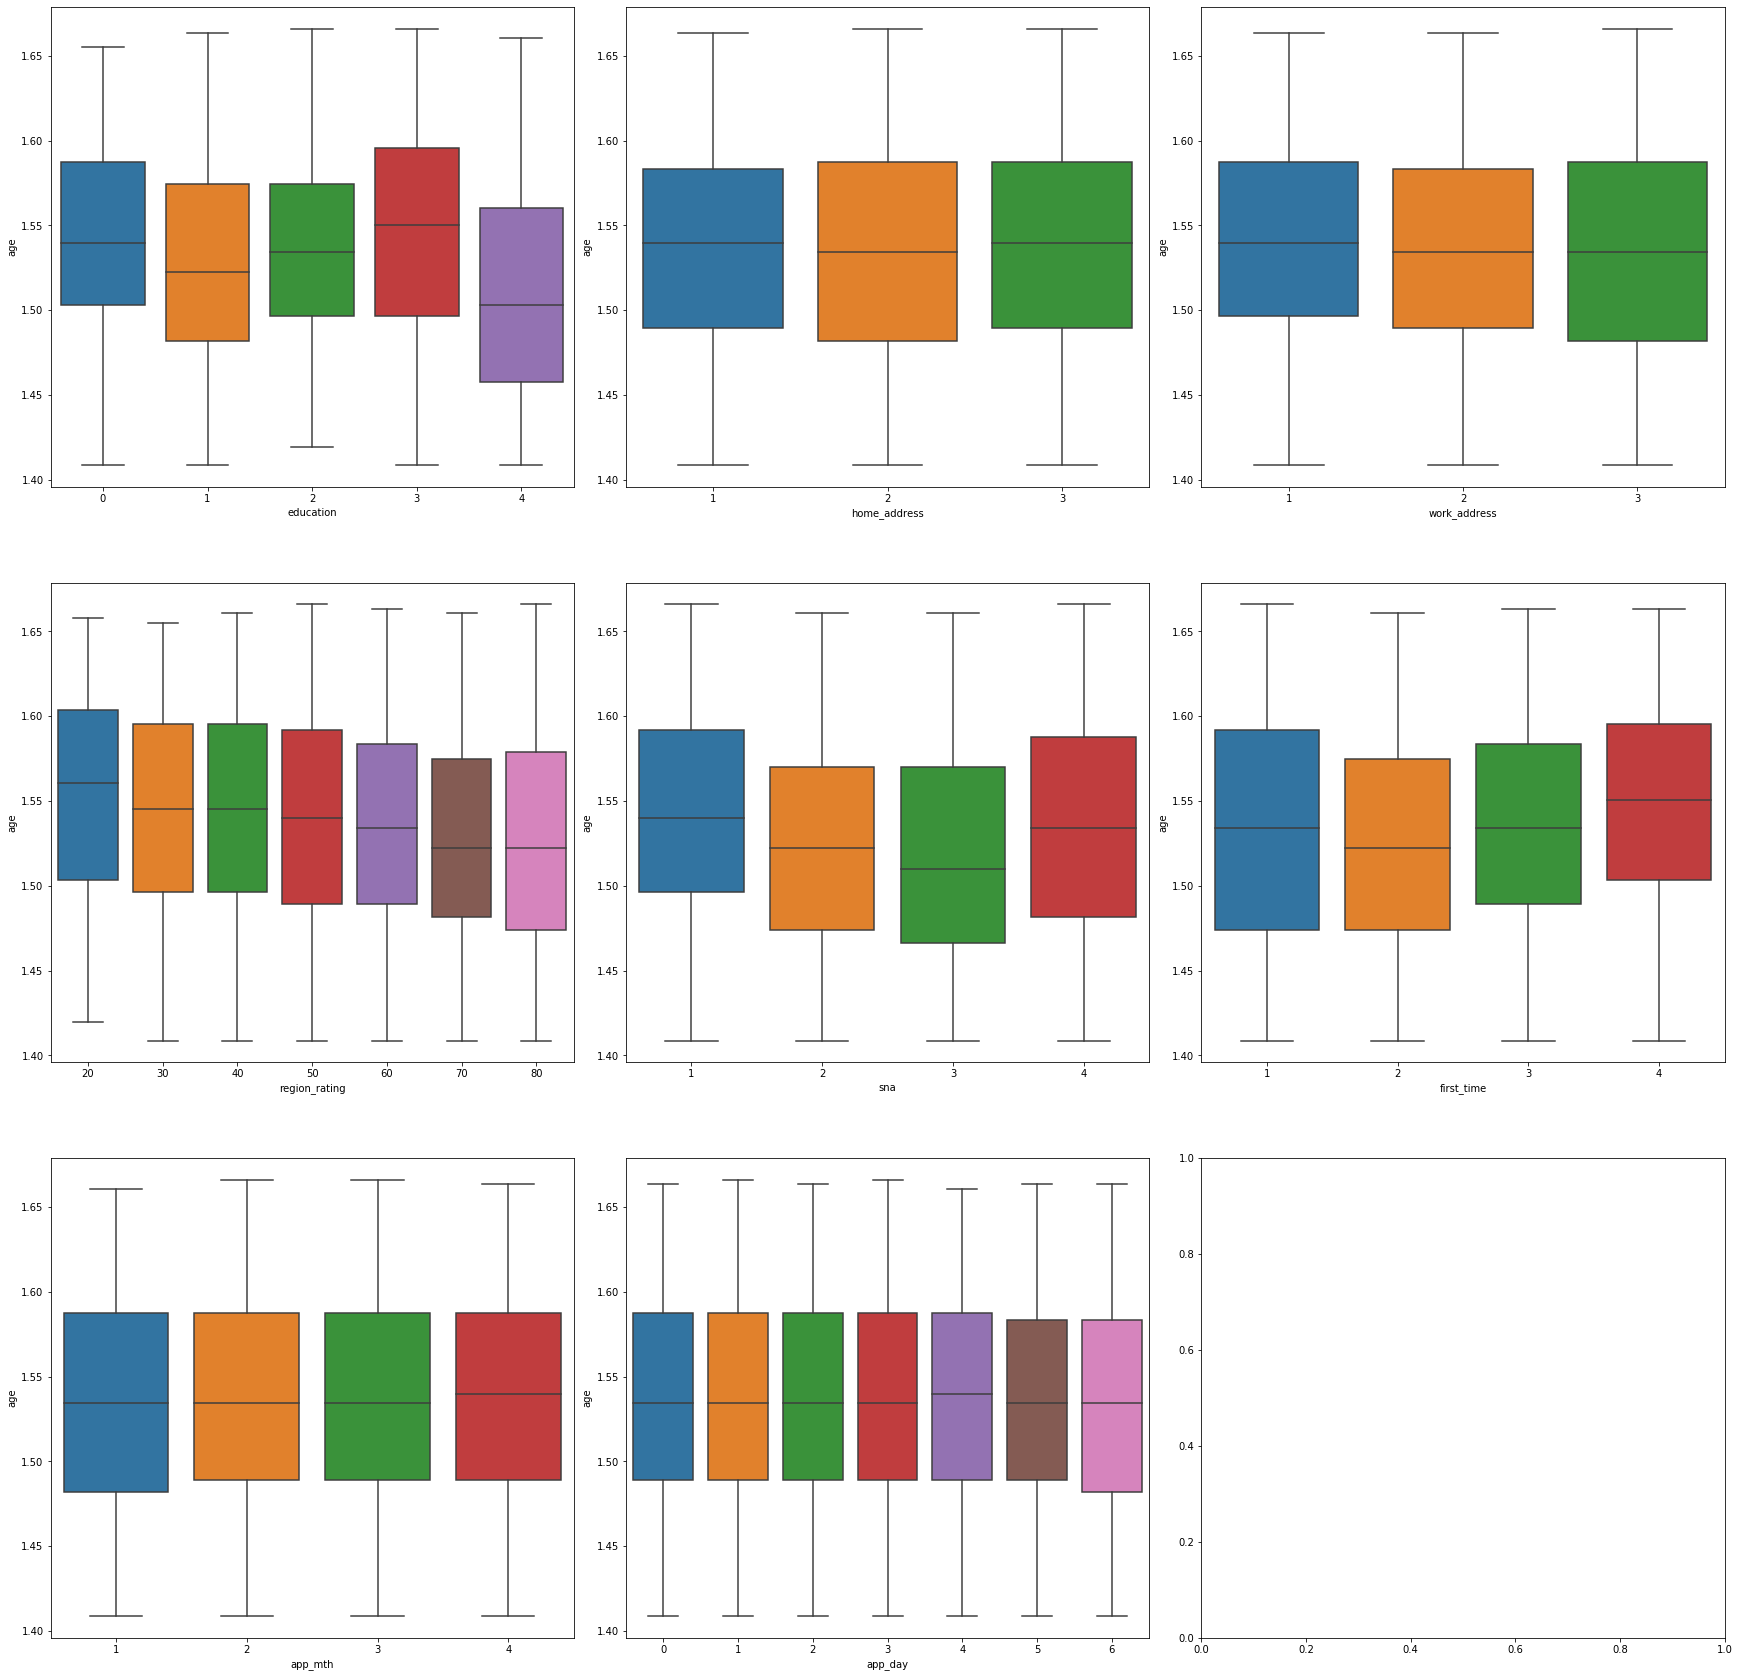

In [628]:
# Зависимость age (возраст) от категориальных признаков.
fig, axes = plt.subplots(3,3, figsize=(30,30))
plt.subplots_adjust(wspace = 0.1)
axes = axes.flatten()
for i in range(len(cat_cols)):
    sns.boxplot(x=cat_cols[i], y="age", data=df, orient = 'v', ax=axes[i], showfliers=False)

Выводы:

1. Уровень запрплаты в среднем не зависит от уровня образования
2. Чем выше рейтинг региона, тем в среднем выше уровень зарплаты
3. Уровень зарплаты практически не зависит от адреса проживания и работы
4. Чем выше уровень зарплаты, тем ниже индекс связи заемщика с клиентами банка
5. Чем выше уровень зарплаты, тем выше признак давности наличия информации о заемщике
5. Клиенты мужского пола в среднем получают более высокую зарплату
6. Клиенты с болеее высокой зарплатой чаще имеют машину, у них есть хорошая работа, они чаще выезжают за границу (на отдых)
7. Чем выше индекс образования, тем, в-среднем, ниже скоринговый балл
8. Скоринговый балл не зависит от адреса проживания и работы, рейтинга региона и индекса связи заемщика с клиентами банка
9. Чем выше значение индекса давности наличия информации о заемщике, тем, в-среднем, выше скоринговый балл
10. Более молодые клиенты предпочитают проживать в регионах с более высоким рейтингом
11. Среди клиентов мужчины раньше начинают обращаться в банки, также мужчины раньше покупают машину, получают хорошую работу и оформляют загранпаспорт

In [ ]:
data_copy = df.copy()  # Запоминаем  датасет 

In [ ]:
df.head()

- Преобразуем категориальные признаки в бинарные, используя dummies(оцифровка).

In [505]:
df = pd.get_dummies(df, columns=cat_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 50 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   sex               110148 non-null  int64  
 2   age               110148 non-null  float64
 3   car               110148 non-null  int64  
 4   car_type          110148 non-null  int64  
 5   decline_app_cnt   110148 non-null  float64
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  float64
 9   income            110148 non-null  float64
 10  foreign_passport  110148 non-null  int64  
 11  sample            110148 non-null  int64  
 12  default           110148 non-null  int64  
 13  education_0       110148 non-null  uint8  
 14  education_1       110148 non-null  uint8  
 15  education_2       110148 non-null  uint8  
 16  education_3       11

In [506]:
# Проверяем результат  
df.head()

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,...,app_mth_2,app_mth_3,app_mth_4,app_day_0,app_day_1,app_day_2,app_day_3,app_day_4,app_day_5,app_day_6
0,74835,1,1.481877,1,1,0.000000,0,1.192148,0.869742,2.469776,...,0,1,0,0,0,0,0,0,1,0
1,17527,0,1.545194,0,0,1.791759,0,0.925070,0.741276,2.253121,...,0,0,0,0,0,0,0,1,0,0
2,75683,1,1.595709,1,1,0.000000,0,0.996821,0.526589,2.425598,...,0,1,0,0,0,0,0,0,0,1
3,26883,1,1.618011,0,0,0.000000,0,1.222935,0.526589,2.374071,...,1,0,0,1,0,0,0,0,0,0
4,28862,0,1.539779,0,0,0.000000,0,1.255968,0.000000,2.541228,...,1,0,0,0,1,0,0,0,0,0


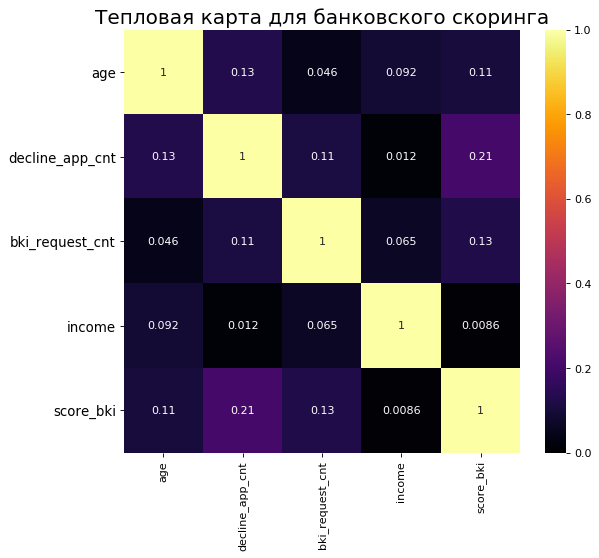

In [507]:
plt.figure(figsize=(8, 7), dpi= 80)
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, cmap = 'inferno')

plt.title('Тепловая карта для банковского скоринга', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.show()


Существенных корреляций нет, все столбцы можно оставить.

In [508]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 50 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   sex               110148 non-null  int64  
 2   age               110148 non-null  float64
 3   car               110148 non-null  int64  
 4   car_type          110148 non-null  int64  
 5   decline_app_cnt   110148 non-null  float64
 6   good_work         110148 non-null  int64  
 7   score_bki         110148 non-null  float64
 8   bki_request_cnt   110148 non-null  float64
 9   income            110148 non-null  float64
 10  foreign_passport  110148 non-null  int64  
 11  sample            110148 non-null  int64  
 12  default           110148 non-null  int64  
 13  education_0       110148 non-null  uint8  
 14  education_1       110148 non-null  uint8  
 15  education_2       110148 non-null  uint8  
 16  education_3       11

In [509]:
df.shape

(110148, 50)

### 3. Подготовка данных к машинному обучению


In [510]:
df_train = df.query('sample == 1').drop(['sample', 'client_id'], axis=1)
df_test = df.query('sample == 0').drop(['default'], axis=1)
id_sub = df_test[['client_id', 'sample']]

In [511]:
df_test.drop(['client_id', 'sample'], axis = 1, inplace=True)
id_sub.drop(['sample'], axis=1, inplace=True)

In [512]:
y = df_train['default']
X = df_train.drop(['default'], axis=1)

In [513]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 47), (14760, 47), (59039,), (14760,))

Стандартизируем числовые переменные:

In [514]:
#X_num = StandardScaler().fit_transform(data[num_cols].values)
#Тренировочный датасет
X_num_train = StandardScaler().fit_transform(df_train[num_cols].values)
# Тестовый датасет
X_num_test = StandardScaler().fit_transform(df_test[num_cols].values)

In [630]:
# Формируем датасеты с категориальными переменными

# Тренировочный датасет
df_cat_train = df_train.drop(["default"], axis = 1)
df_cat_train.drop(num_cols, axis = 1, inplace = True)

# Тестовый датасет
df_cat_test = df_test.drop(num_cols, axis = 1)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [516]:
# Объединяем цифровые, бинарные и категориальные оцифрованные признаки в одну матрицу (в одно признаковое пространство)

# Тренировочные данные
X_1 = np.hstack([X_num_train, df_cat_train.values])

# Тестовые данные
X_t_1 = np.hstack([X_num_test, df_cat_test.values])

In [517]:
# Целевая переменная
y_1 = train_data['default'].values

In [518]:
print(X_1.shape, X_t_1.shape, y_1.shape)

(73799, 47) (36349, 47) (73799,)


### 4.1 МОДЕЛЬ 1 (базовая)
Первую (базовую) модель построим по всем признакам без фильтрации
##### Обучение модели логистической регрессии
Разделим данные для обучения следующим образом:

In [519]:
model_1 = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
model_1.fit(X_train, y_train)

# Предсказываем целевую переменную и вероятностные оценки
y_pred_prob = model_1.predict_proba(X_test)[:,1]
y_pred = model_1.predict(X_test)

# Выводим метрики модели
metrics_total(y_test, y_pred, y_pred_prob)

,Metrics,Result,Description
P,Positive,1827.000000,Default
N,Negative,12933.000000,Non-Default
TP,True positive,44.000000,True default
TN,True Negative,12859.000000,True Non-Default
FP,False Positive,74.000000,False default
FN,False Negative,1783.000000,False non-default
Accuracy,Accuracy,0.874187,Accuracy=(TP+TN)/(TP+TN+FP+FN)
Precision,Precision,0.372881,Precision = TP/(TP+FP)
Recall,Recall,0.024083,Recall = TP/(TP+FN)
F1-score,F-metrics,0.045244,Weigted average Precision & Recall


Создадим датафрейм всех метрик для наглядности.

In [520]:
lst_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC_AUC']
df_comp = pd.DataFrame(lst_metrics)
df_comp.columns = ['Metrics']
df_comp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Metrics  5 non-null      object
dtypes: object(1)
memory usage: 168.0+ bytes


In [521]:
df_comp = cumulated_res(df_comp, 'model_1', y_test, y_pred, y_pred_prob)
df_comp

,Metrics,model_1
0,Accuracy,0.874187
1,Precision,0.372881
2,Recall,0.024083
3,F1-score,0.045244
4,ROC_AUC,0.744567


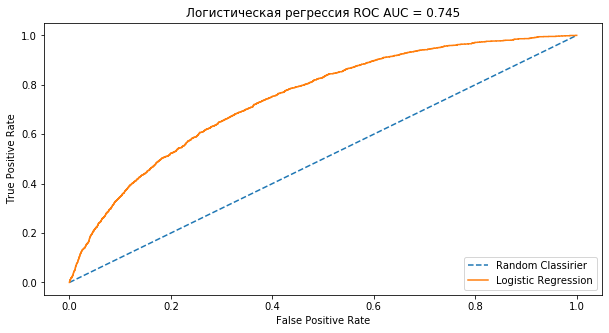

In [522]:
#ROC_AUC
roc_curv(y_test, y_pred_prob)

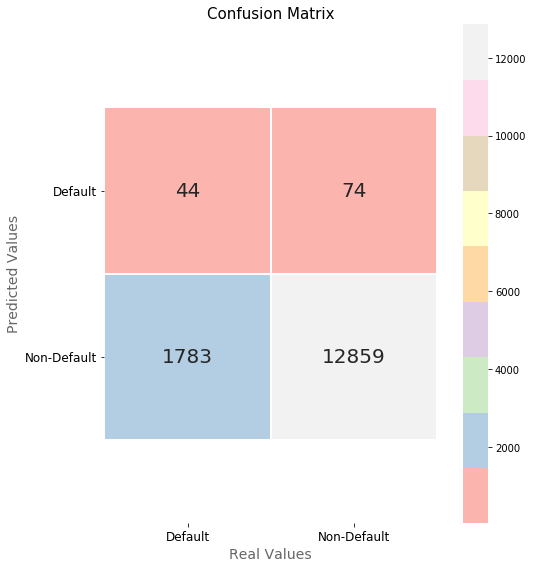

In [523]:
#Confusion matrix
conf_matr(y_test, y_pred)

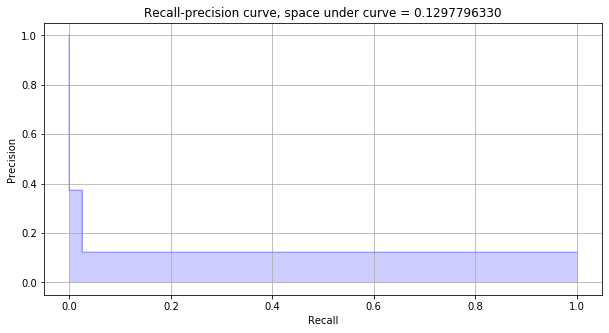

In [524]:
# precision - recall
recall_precision_plot(y_test, y_pred)

#### Вывод
В этой простой модели recall и F1-score очень низкиe. 
f1_score = 0.045 recall = 0.024. Из 1827 дефолтных клиентов модель угадала лишь 44.
Это ошибка второго рода. В данном случае метрика ROC-AUC (0.743) не показательна, поскольку мы имеем дело с несбалансированной моделью.
Попробуем улучшить модель.

В качестве методов оценки прогностической способности модели мы решаем использовать ROC-анализ.

Вспоминая из модуля по Классификации, что классификатор имеет параметр порог отсечения. Изменяя его значение, мы получаем то или иное разбиение на два класса — класс с положительными исходами и класс с отрицательными исходами.

- В нашем примере положительным исходом будет наличие дефолта у заемщика, 
- отрицательным — отсутствие дефолта.



→ Доля положительных результатов у «плохих» заемщиков (истинно положительных результатов) — это чувствительность модели (Sensitivity), то есть способность модели правильно определять «плохих» заемщиков и минимизировать убытки, связанные с выдачей кредита «плохому» клиенту. 

→ Доля отрицательных результатов у «хороших» заемщиков (истинно отрицательных результатов) — это специфичность модели (Specificity). Здесь речь уже идёт о способности модели правильно определять «хороших» заемщиков и минимизировать убытки, связанные с отказом в выдаче кредита добросовестному клиенту. 



Давайте найдем оптимальное значение параметра регуляризации для логистической регрессии. 



### 3.2 Модель 2 
Модель с балансировкой признаков

In [407]:
model_2 = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
model_2.fit(X_train, y_train)

# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_2.predict_proba(X_test)[:,1]
y_pred = model_2.predict(X_test)

# Оценка качества модели
metrics_total(y_test, y_pred, y_pred_prob)

,Metrics,Result,Description
P,Positive,1827.000000,Default
N,Negative,12933.000000,Non-Default
TP,True positive,1234.000000,True default
TN,True Negative,8690.000000,True Non-Default
FP,False Positive,4243.000000,False default
FN,False Negative,593.000000,False non-default
Accuracy,Accuracy,0.672358,Accuracy=(TP+TN)/(TP+TN+FP+FN)
Precision,Precision,0.225306,Precision = TP/(TP+FP)
Recall,Recall,0.675424,Recall = TP/(TP+FN)
F1-score,F-metrics,0.337897,Weigted average Precision & Recall


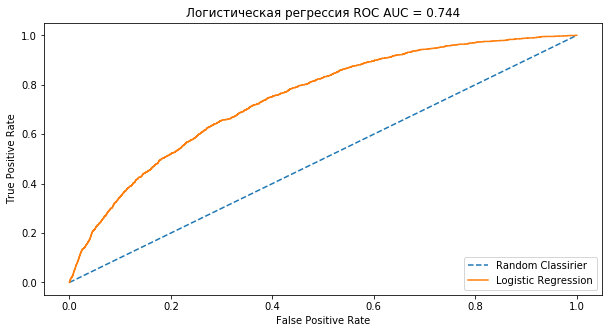

In [408]:
#Кривая ROC_AUC
roc_curv(y_test, y_pred_prob)


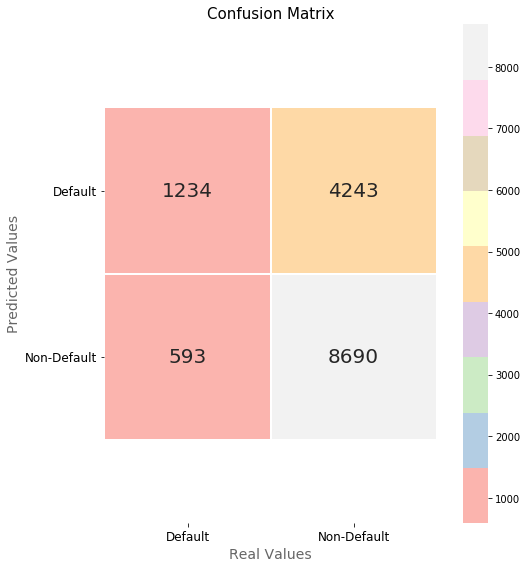

In [409]:
#Confusion matrix
conf_matr(y_test, y_pred)

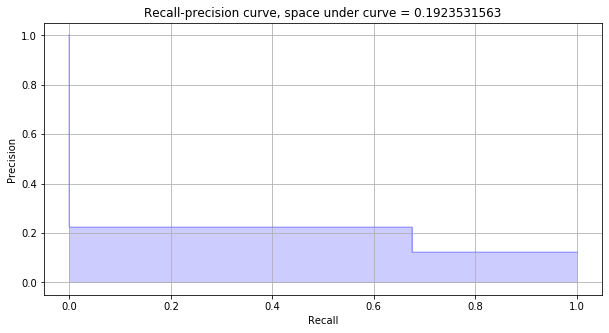

In [410]:
#Кривая precision - recall
recall_precision_plot(y_test, y_pred)

In [411]:
df_comp = cumulated_res(df_comp, 'model_2', y_test, y_pred, y_pred_prob)
df_comp

,Metrics,model_1,model_2
0,Accuracy,0.874187,0.672358
1,Precision,0.372881,0.225306
2,Recall,0.024083,0.675424
3,F1-score,0.045244,0.337897
4,ROC_AUC,0.744567,0.744432


!Вывод
- Accuracy и Precision заметно уменьшились
- значительно выросли F-1 и Recall. 
- Видно, что модель стала большему количеству заявителей предсказывать дефолт.
- Значени ROC-AUC немного понизилось. 
Попробуем поработать над данными.

### 3.3 Модель 3

Запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой остановки tol1e-3,
чтобы получить оптимальные параметры модели в первом приближении.

In [412]:
model = LogisticRegression(random_state=RANDOM_SEED)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False


Запустим модель с полученными метриками

In [413]:
model_3 = LogisticRegression(C = 1.0, class_weight = 'balanced', dual = False, fit_intercept = True,
                             intercept_scaling = 1, l1_ratio = None, max_iter = 50, multi_class = 'auto',
                             n_jobs = None, penalty = 'none', random_state = 42, solver = 'saga', tol = 0.001,
                             verbose = 0, warm_start = False)
model_3.fit(X_train, y_train)
# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_3.predict_proba(X_test)[:,1]
y_pred = model_3.predict(X_test)

In [414]:
# Оценка качества модели
metrics_total(y_test, y_pred, y_pred_prob)

,Metrics,Result,Description
P,Positive,1827.000000,Default
N,Negative,12933.000000,Non-Default
TP,True positive,1235.000000,True default
TN,True Negative,8678.000000,True Non-Default
FP,False Positive,4255.000000,False default
FN,False Negative,592.000000,False non-default
Accuracy,Accuracy,0.671612,Accuracy=(TP+TN)/(TP+TN+FP+FN)
Precision,Precision,0.224954,Precision = TP/(TP+FP)
Recall,Recall,0.675972,Recall = TP/(TP+FN)
F1-score,F-metrics,0.337570,Weigted average Precision & Recall


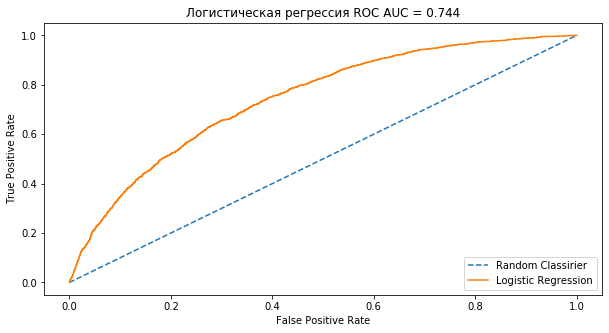

In [415]:
#Кривая ROC_AUC
roc_curv(y_test, y_pred_prob)

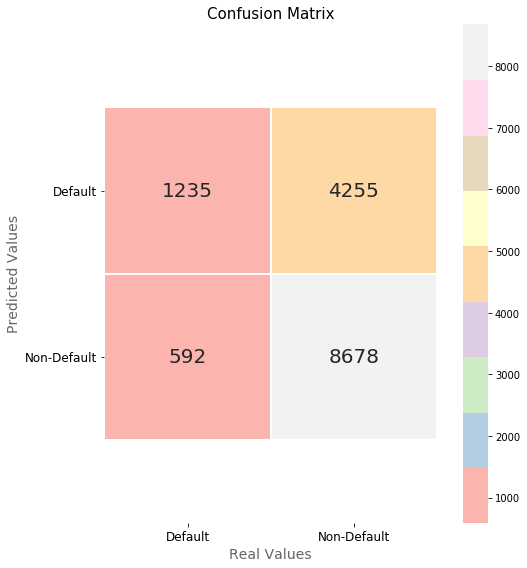

In [416]:
#Confusion matrix
conf_matr(y_test, y_pred)

In [417]:
df_comp = cumulated_res(df_comp, 'model_3', y_test, y_pred, y_pred_prob)
df_comp

,Metrics,model_1,model_2,model_3
0,Accuracy,0.874187,0.672358,0.671612
1,Precision,0.372881,0.225306,0.224954
2,Recall,0.024083,0.675424,0.675972
3,F1-score,0.045244,0.337897,0.337570
4,ROC_AUC,0.744567,0.744432,0.744420


Метрики слегка стали хуже. 

### 3.4 Модель 4

Изменим регуляризацию С до 0.5 и увеличим количество итераций до 1000, а также введем штраф.



In [418]:
model_4 = LogisticRegression(C = 0.5, class_weight = 'balanced', dual = False, fit_intercept = True,
                             intercept_scaling = 1, l1_ratio = None, max_iter = 1000, multi_class = 'auto',
                             n_jobs = None, penalty = 'l2', solver = 'saga', tol = 0.001,
                             verbose = 0, warm_start = False)
model_4.fit(X_train, y_train)
# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_4.predict_proba(X_test)[:,1]
y_pred = model_4.predict(X_test)


In [419]:
# Оценка качества модели
metrics_total(y_test, y_pred, y_pred_prob)

,Metrics,Result,Description
P,Positive,1827.000000,Default
N,Negative,12933.000000,Non-Default
TP,True positive,1235.000000,True default
TN,True Negative,8691.000000,True Non-Default
FP,False Positive,4242.000000,False default
FN,False Negative,592.000000,False non-default
Accuracy,Accuracy,0.672493,Accuracy=(TP+TN)/(TP+TN+FP+FN)
Precision,Precision,0.225488,Precision = TP/(TP+FP)
Recall,Recall,0.675972,Recall = TP/(TP+FN)
F1-score,F-metrics,0.338171,Weigted average Precision & Recall


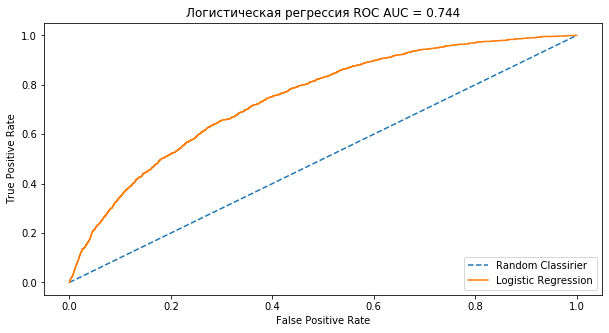

In [420]:
#Кривая ROC_AUC
roc_curv(y_test, y_pred_prob)

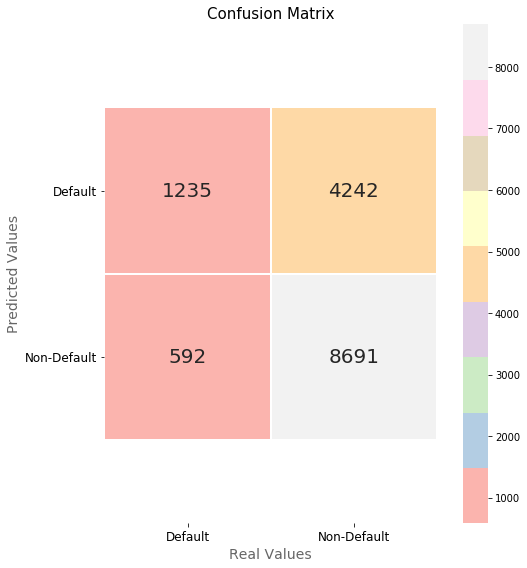

In [421]:
#Confusion matrix
conf_matr(y_test, y_pred)

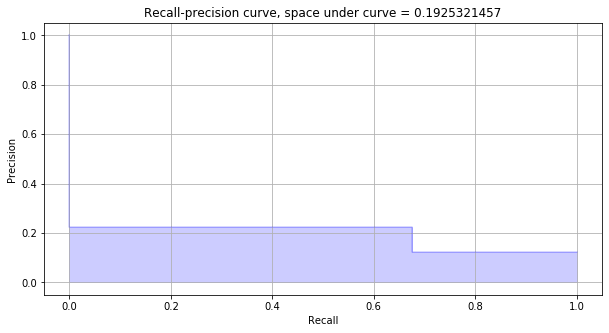

In [422]:
recall_precision_plot(y_test, y_pred)

In [423]:
df_comp = cumulated_res(df_comp, 'model_4', y_test, y_pred, y_pred_prob)
df_comp

,Metrics,model_1,model_2,model_3,model_4
0,Accuracy,0.874187,0.672358,0.671612,0.672493
1,Precision,0.372881,0.225306,0.224954,0.225488
2,Recall,0.024083,0.675424,0.675972,0.675972
3,F1-score,0.045244,0.337897,0.337570,0.338171
4,ROC_AUC,0.744567,0.744432,0.744420,0.744445


В четвертой модели метрики качества улучшились совершенно незначительно.

### 4. Submission

In [424]:
X_final = df_test
y_pred_prob_f = model_5.predict_proba(X_final)[:,1]
y_pred_f = model_5.predict(X_final)

submit = id_sub
submit['default'] = y_pred_prob_f

In [425]:
submit.to_csv('submission.csv', index=False)

In [426]:
submit

,client_id,default
0,74835,0.228240
1,17527,0.771585
2,75683,0.325448
3,26883,0.414593
4,28862,0.145000
...,...,...
36344,83775,0.789126
36345,106254,0.110750
36346,81852,0.821299
36347,1971,0.613221


#### Заключение

В ходе усложнения параметров модели, были получены достаточно хорошие значения метрик. Модель, конечно же, далека от идеала. Но тем не менее удалось в несколько десятков раз ее улучшить. 

In [ ]:
0.73660 #значение метрики на каггле